In [1]:
%matplotlib inline

In [2]:
import requests
from astropy.cosmology import WMAP7
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import numpy as np
import sympy as sp
import math as m
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from astropy.io import fits
import os
from astropy.table import Table
import astropy.constants as cons
from scipy import interpolate
from uncertainties import ufloat
import pickle
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import linregress
from ltsfit.lts_linefit import lts_linefit

import photutils
from photutils.aperture import aperture_photometry
from photutils.segmentation import detect_sources,detect_threshold,SourceCatalog,deblend_sources
from photutils.background import Background2D, MedianBackground
from photutils.aperture import EllipticalAperture
from photutils.aperture import CircularAperture

from point_source import create_PS
from bgrms import bgrms
from cluster_contamination import cluster_contamination
from contamination_estimator import contamination_estimator

from multiprocessing import Pool
import time
import emcee
# import corner
from scipy.optimize import minimize


import warnings
warnings.filterwarnings('ignore')
os.environ["OMP_NUM_THREADS"] = "1"


def reject_outliers(data):
    m = 3
    u = np.median(data)
    residuals = np.array(data)-u
    s = np.sqrt(np.mean(np.array(residuals)**2))
    filtered = [e for e in data if (u - m * s < e < u + m * s)]
    return np.array(filtered)

def find_outliers(residuals,sigma):
    m = sigma
    u = np.median(residuals)
    s = np.sqrt(np.mean(np.array(residuals)**2))
    select = np.where((residuals>u-m*s)&(residuals<u+m*s))
    return select

current_path = os.getcwd()
current_path

'/Users/dukaiyi/Documents/PhD_Thesis/kSZE/Kinematic_SZ/simulations/TNG'

In [3]:
# result.keys()
# dict_keys(['ID', 'redshift', 'vz_real', 'vz_gas', 'bands', 'resolution', 'R200', 'R200_arcsec', 'R500', 'R500_arcsec',
#            'c200', 'aperture_rad', 'DI_SZ_R200', 'DI_SZ_R500', 'DI_SZ_halfR500', 'DI_SZ_qrR500', 'DI_SZ_R200_pure',
#            'DI_SZ_R500_pure', 'DI_SZ_halfR500_pure', 'DI_SZ_qrR500_pure', 'DI_SZ_R200_subPS', 'DI_SZ_R500_subPS', 
#            'DI_SZ_halfR500_subPS', 'DI_SZ_qrR500_subPS', 'fsh_mass', 'fsh_cell', 'vz_mass_weighted', 'vz_obs_pure',
#            'vz_obs_pure_err'])

In [4]:
# GC_gas.keys()
# dict_keys(['TNG_sim', 'ID', 'redshift', 'total_mass', 'vel_x', 'vel_y', 'vel_z', 'pos_x', 'pos_y', 'pos_z', 
#            'Coordinates_x', 'Coordinates_y', 'Coordinates_z', 'dx', 'dy', 'dz', 'Density', 'Masses', 'SFR', 
#            'X_e', 'X_H', 'vx', 'vy', 'vz', 'InternalEnergy', 'n_e', 'n_H', 'OpticalDepth', 'Tgas', 'cell_size_kpc',
#            'Machnumber', 'AGNRadiation'])

In [5]:
# GC_BH.keys()
# dict_keys(['TNG_sim', 'ID', 'redshift', 'BH_ID', 'dx', 'dy', 'dz', 'total_mass', 'vx', 'vy', 'vz', 
#            'BH_Mass', 'BH_Mdot', 'AGN_th_fb', 'AGN_nonth_fb'])#

# Galaxy cluster sample redshift distribution

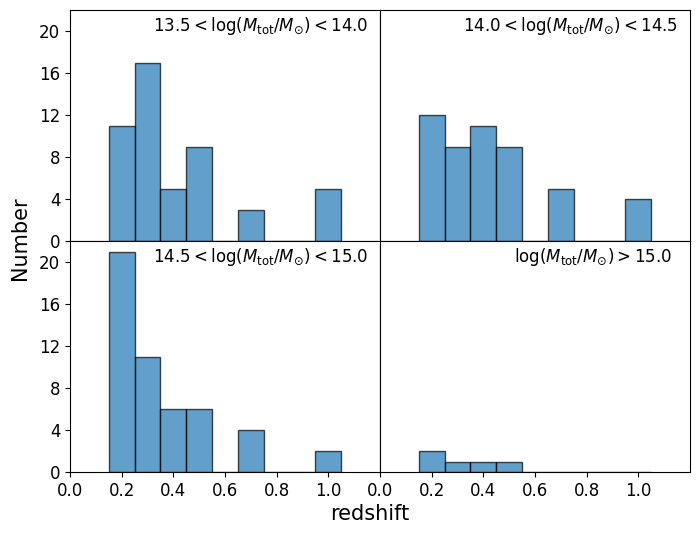

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
BIN = [0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05]

masses = []
redshifts = []
for mass_range in [1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            info = pickle.load(open(current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl','rb'))
            redshifts.append(info['redshift'])
            masses.append(info['total_mass'])

redshifts = np.array(redshifts)
masses = np.array(masses)
ax[0][0].hist(redshifts, bins=BIN, ec='k', fc=None, alpha=0.7)
ax[0][0].set_xticks([])
ax[0][0].set_yticks(np.arange(0, 22, step=4))
ax[0][0].set_yticklabels(np.arange(0, 22, step=4),fontsize=12)
ax[0][0].text(0.32,20,r'$13.5<{\rm log}(M_{\rm tot}/M_{\odot})<14.0$',fontsize=12)
ax[0][0].set_xlim(0,1.2)
ax[0][0].set_ylim(0,22)

masses = []
redshifts = []
for mass_range in [2]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            info = pickle.load(open(current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl','rb'))
            redshifts.append(info['redshift'])
            masses.append(info['total_mass'])

redshifts = np.array(redshifts)
masses = np.array(masses)
ax[0][1].hist(redshifts, bins=BIN, ec='k', fc=None, alpha=0.7)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])
ax[0][1].text(0.32,20,r'$14.0<{\rm log}(M_{\rm tot}/M_{\odot})<14.5$',fontsize=12)
ax[0][1].set_xlim(0,1.2)
ax[0][1].set_ylim(0,22)

masses = []
redshifts = []
for mass_range in [3]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            info = pickle.load(open(current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl','rb'))
            redshifts.append(info['redshift'])
            masses.append(info['total_mass'])

redshifts = np.array(redshifts)
masses = np.array(masses)
ax[1][0].hist(redshifts, bins=BIN, ec='k', fc=None, alpha=0.7)
ax[1][0].set_xticks(np.arange(0, 1.2, step=0.2))
ax[1][0].set_xticklabels([0. , 0.2, 0.4, 0.6, 0.8, 1. ],fontsize=12)
ax[1][0].set_yticks(np.arange(0, 22, step=4))
ax[1][0].set_yticklabels(np.arange(0, 22, step=4),fontsize=12)
ax[1][0].text(0.32,20,r'$14.5<{\rm log}(M_{\rm tot}/M_{\odot})<15.0$',fontsize=12)
ax[1][0].set_xlim(0,1.2)
ax[1][0].set_ylim(0,22)

masses = []
redshifts = []
for mass_range in [4]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            info = pickle.load(open(current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl','rb'))
            redshifts.append(info['redshift'])
            masses.append(info['total_mass'])

redshifts = np.array(redshifts)
masses = np.array(masses)
ax[1][1].hist(redshifts, bins=BIN,ec='k', fc=None, alpha=0.7)
ax[1][1].set_xticks(np.arange(0, 1.2, step=0.2))
ax[1][1].set_xticklabels([0. , 0.2, 0.4, 0.6, 0.8, 1. ],fontsize=12)
ax[1][1].set_yticks([])
ax[1][1].text(0.52,20,r'${\rm log}(M_{\rm tot}/M_{\odot})>15.0$',fontsize=12)
ax[1][1].set_xlim(0,1.2)
ax[1][1].set_ylim(0,22)

fig.subplots_adjust(wspace=0,hspace=0)
fig.text(0.5, 0.03, 'redshift', ha='center',fontsize=15)
fig.text(0.05, 0.5, 'Number', va='center', rotation='vertical',fontsize=15)
png_filename = 'sample_redshift_distribution.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
fig.savefig('sample_redshift_distribution.png',dpi=450)
            
            

# v_{z,gas} with diff aper vs. v_{z,halo}

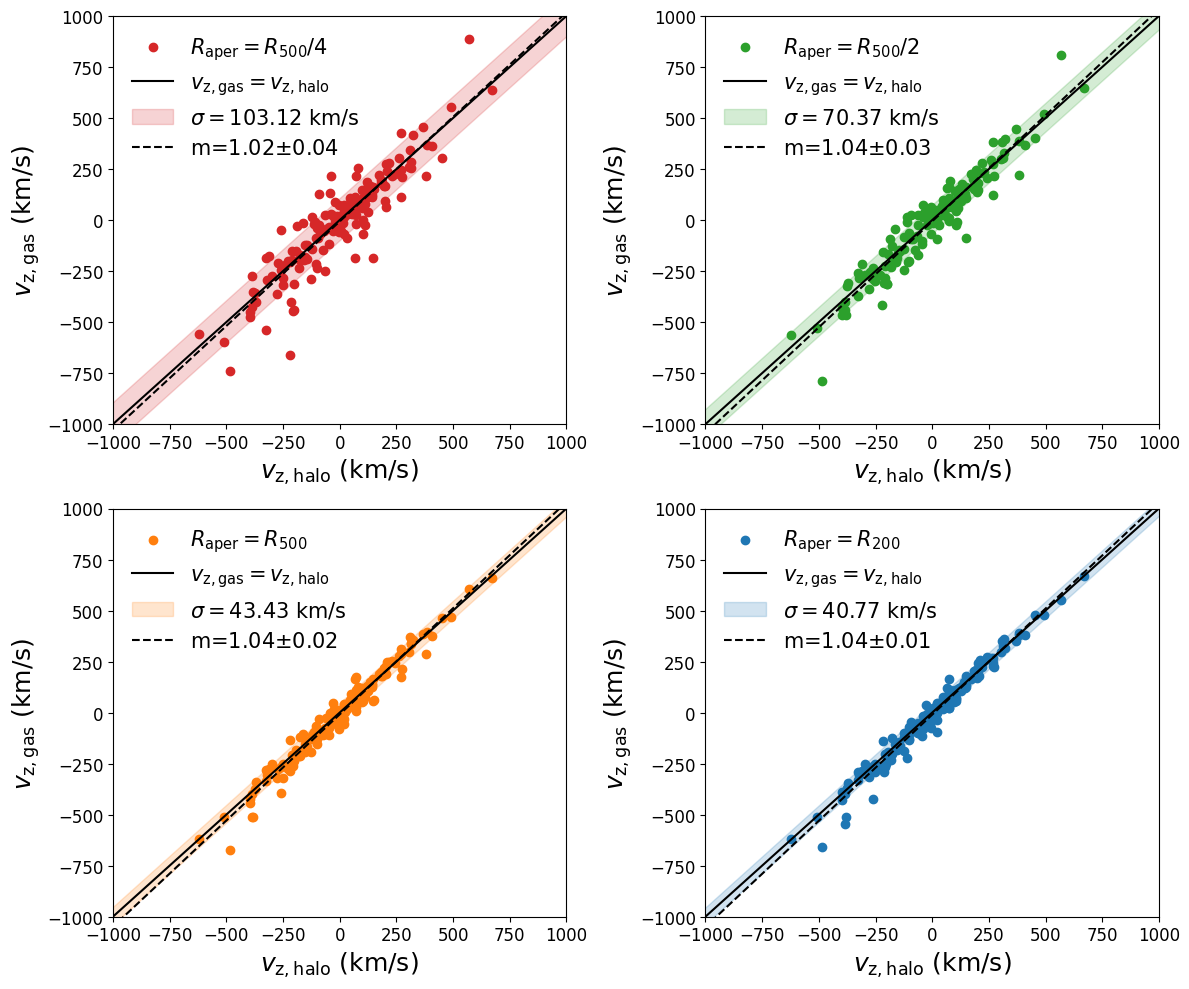

In [45]:
v_true = []
v_qr500_gas = []
v_half500_gas = []
v_500_gas = []
v_200_gas = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
            v_true.append(result['vz_real'])
            v_qr500_gas.append(result['vz_mass_weighted'][0])
            v_half500_gas.append(result['vz_mass_weighted'][1])
            v_500_gas.append(result['vz_mass_weighted'][2])
            v_200_gas.append(result['vz_mass_weighted'][3])
            vdiff_qr500.append(result['vz_mass_weighted'][0]-result['vz_real'])
            vdiff_half500.append(result['vz_mass_weighted'][1]-result['vz_real'])
            vdiff_500.append(result['vz_mass_weighted'][2]-result['vz_real'])
            vdiff_200.append(result['vz_mass_weighted'][3]-result['vz_real'])


axis_lim = 1.5
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

residuals = np.array(v_qr500_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][0].scatter(v_true,v_qr500_gas,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_qr500_gas, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both',which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)

residuals = np.array(v_half500_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][1].scatter(v_true,v_half500_gas,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_half500_gas, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].tick_params(axis='both', which='major', labelsize=12)
axes[0][1].legend(fontsize=15,frameon=0)

residuals = np.array(v_500_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][0].scatter(v_true,v_500_gas,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_500_gas, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].tick_params(axis='both', which='major', labelsize=12)
axes[1][0].legend(fontsize=15,frameon=0)

residuals = np.array(v_200_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][1].scatter(v_true,v_200_gas,label=r'$R_{\rm aper}=R_{200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_200_gas, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
# axes[1][1].set_ylim(np.min(v_true)*axis_lim,np.max(v_true)*axis_lim)
# axes[1][1].set_xlim(np.min(v_true)*axis_lim,np.max(v_true)*axis_lim)
axes[1][1].tick_params(axis='both', which='major', labelsize=12)
axes[1][1].legend(fontsize=15,frameon=0)

plt.tight_layout()
png_filename = 'vgas_vreal_noex.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
plt.savefig('vgas_vreal_noex.png',dpi=450)


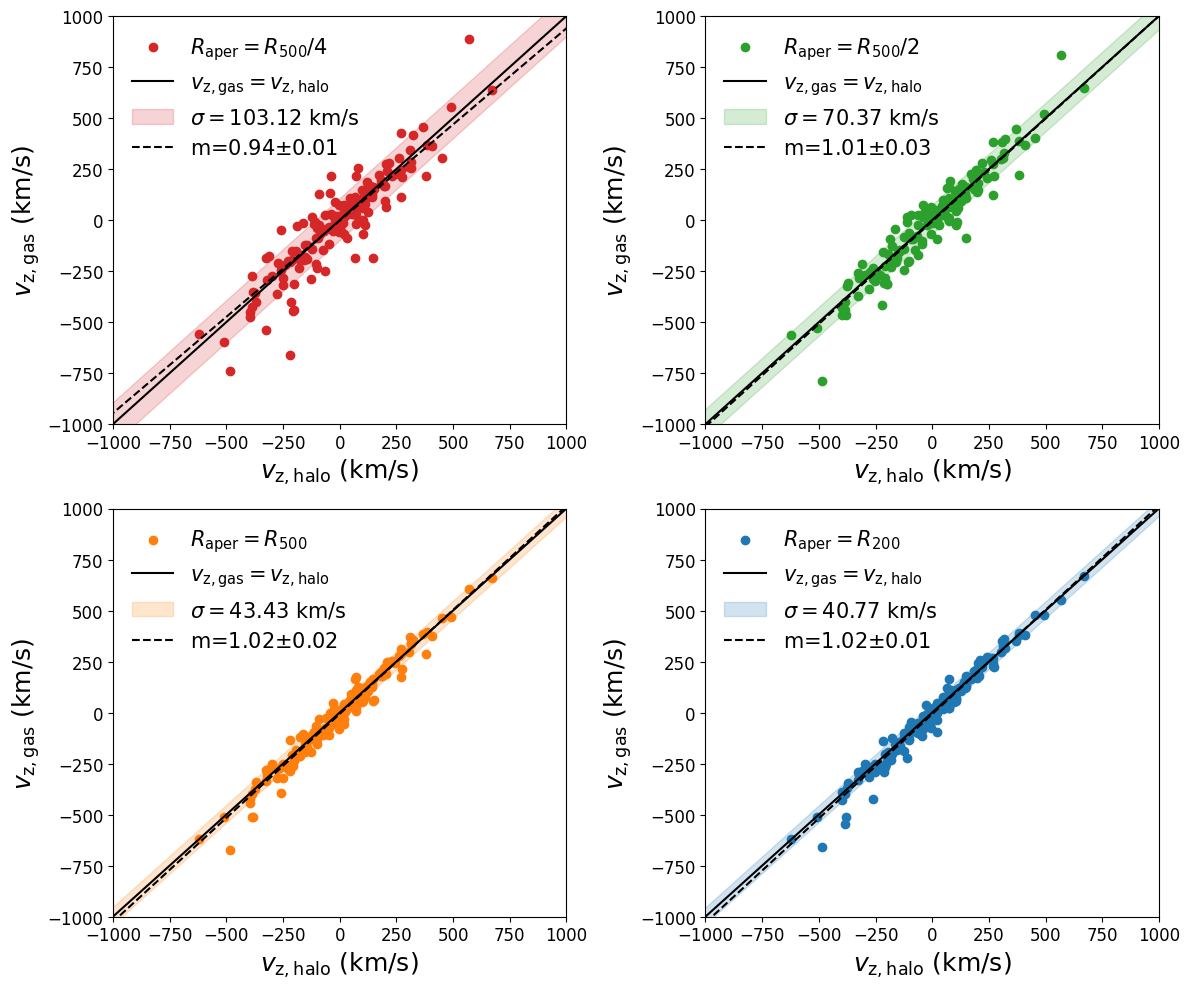

In [46]:
v_true = []
v_qr500_gas = []
v_half500_gas = []
v_500_gas = []
v_200_gas = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
            v_true.append(result['vz_real'])
            v_qr500_gas.append(result['vz_mass_weighted'][0])
            v_half500_gas.append(result['vz_mass_weighted'][1])
            v_500_gas.append(result['vz_mass_weighted'][2])
            v_200_gas.append(result['vz_mass_weighted'][3])
            vdiff_qr500.append(result['vz_mass_weighted'][0]-result['vz_real'])
            vdiff_half500.append(result['vz_mass_weighted'][1]-result['vz_real'])
            vdiff_500.append(result['vz_mass_weighted'][2]-result['vz_real'])
            vdiff_200.append(result['vz_mass_weighted'][3]-result['vz_real'])


axis_lim = 1.5
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))


residuals = np.array(v_qr500_gas) - np.array(v_true)
std = np.sqrt(np.mean((residuals)**2))
axes[0][0].scatter(v_true,v_qr500_gas,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label=r'$\sigma=$'+str(round(std,2))+' km/s')
# exclude_outiers = find_outliers(residuals,3)
exclude_outiers = (np.array(v_qr500_gas) >= -500) & (np.array(v_qr500_gas) <= 500)
popt, pov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_qr500_gas)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both',which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)

residuals = np.array(v_half500_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][1].scatter(v_true,v_half500_gas,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label=r'$\sigma=$'+str(round(std,2))+' km/s')
# exclude_outiers = find_outliers(residuals,3)
exclude_outiers = (np.array(v_half500_gas) >= -500) & (np.array(v_half500_gas) <= 500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_half500_gas)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].tick_params(axis='both', which='major', labelsize=12)
axes[0][1].legend(fontsize=15,frameon=0)

residuals = np.array(v_500_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][0].scatter(v_true,v_500_gas,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label=r'$\sigma=$'+str(round(std,2))+' km/s')
# exclude_outiers = find_outliers(residuals,3)
exclude_outiers = (np.array(v_500_gas) >= -500) & (np.array(v_500_gas) <= 500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_500_gas)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].tick_params(axis='both', which='major', labelsize=12)
axes[1][0].legend(fontsize=15,frameon=0)

residuals = np.array(v_200_gas) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][1].scatter(v_true,v_200_gas,label=r'$R_{\rm aper}=R_{200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,gas}=v_{\rm z,halo}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label=r'$\sigma=$'+str(round(std,2))+' km/s')
# exclude_outiers = find_outliers(residuals,3)
exclude_outiers = (np.array(v_200_gas) >= -500) & (np.array(v_200_gas) <= 500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_200_gas)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].tick_params(axis='both', which='major', labelsize=12)
axes[1][1].legend(fontsize=15,frameon=0)

plt.tight_layout()
png_filename = 'vgas_vreal_Tx_ex500.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
plt.savefig('vgas_vreal_ex500.png',dpi=450)


# v_{z,kSZ} vs. v_{z,halo}

## v_{z,kSZ} vs. v_{z,halo}

### No exclusion polyfit

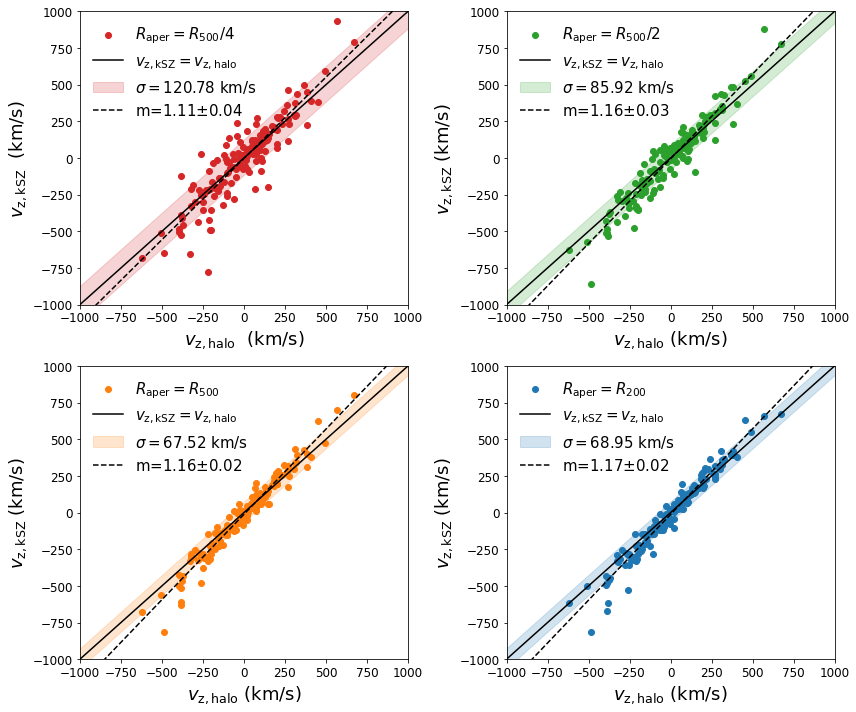

In [27]:
v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
            v_true.append(result['vz_real'])
            v_qr500_obs.append(result['vz_obs_pure_CF'][0])
            v_half500_obs.append(result['vz_obs_pure_CF'][1])
            v_500_obs.append(result['vz_obs_pure_CF'][2])
            v_200_obs.append(result['vz_obs_pure_CF'][3])
            vdiff_qr500.append(result['vz_obs_pure_CF'][0]-result['vz_real'])
            vdiff_half500.append(result['vz_obs_pure_CF'][1]-result['vz_real'])
            vdiff_500.append(result['vz_obs_pure_CF'][2]-result['vz_real'])
            vdiff_200.append(result['vz_obs_pure_CF'][3]-result['vz_real'])


axis_lim = 1.8
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

residuals = np.array(v_qr500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][0].scatter(v_true,v_qr500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_qr500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$  (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$  (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major', labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
# axes[0][0].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][0].legend(fontsize=15,frameon=0,loc='upper left')

residuals = np.array(v_half500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][1].scatter(v_true,v_half500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true, v_half500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major', labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
# axes[0][1].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][1].legend(fontsize=15,frameon=0,loc='upper left')

residuals = np.array(v_500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][0].scatter(v_true,v_500_obs,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major', labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
# axes[1][0].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[1][0].legend(fontsize=15,frameon=0,loc='upper left')

residuals = np.array(v_200_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][1].scatter(v_true,v_200_obs,label=r'$R_{\rm aper}=R_{\rm 200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_200_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major', labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0,loc='upper left')
plt.tight_layout()
plt.savefig('vobs_vreal_polyfit_noex_Tx.png',overwrite=True,dpi=450)


#### no initial parameters

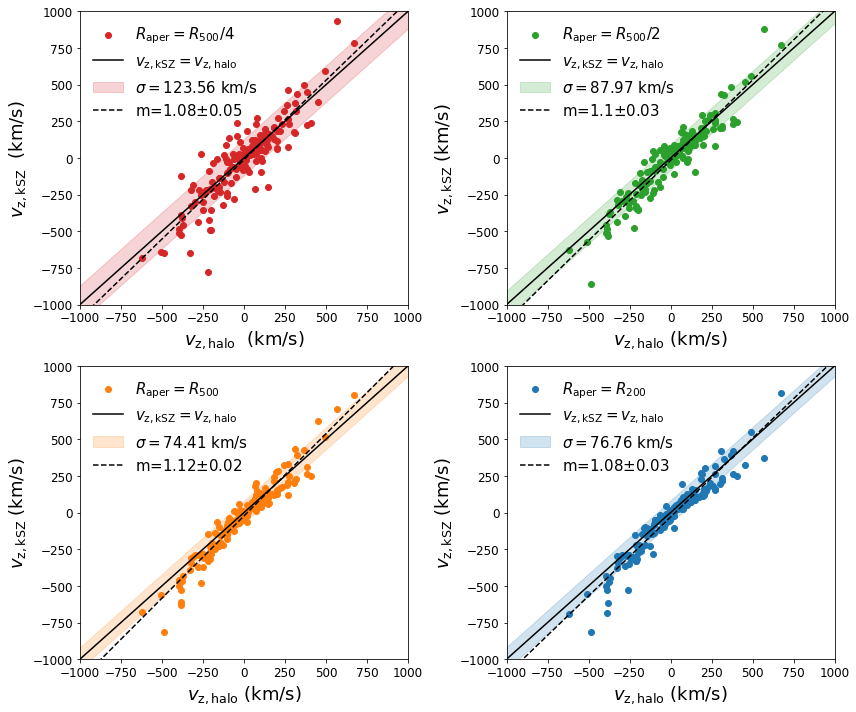

In [28]:
v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
            v_true.append(result['vz_real'])
            v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
            v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
            v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])
            v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
            vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_real'])
            vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_real'])
            vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_real'])
            vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_real'])


axis_lim = 1.8
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

residuals = np.array(v_qr500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][0].scatter(v_true,v_qr500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_qr500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$  (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$  (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major', labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
# axes[0][0].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][0].legend(fontsize=15,frameon=0,loc='upper left')

residuals = np.array(v_half500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][1].scatter(v_true,v_half500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true, v_half500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major', labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
# axes[0][1].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][1].legend(fontsize=15,frameon=0,loc='upper left')

residuals = np.array(v_500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][0].scatter(v_true,v_500_obs,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major', labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
# axes[1][0].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[1][0].legend(fontsize=15,frameon=0,loc='upper left')

residuals = np.array(v_200_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][1].scatter(v_true,v_200_obs,label=r'$R_{\rm aper}=R_{\rm 200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_true,v_200_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major', labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0,loc='upper left')
plt.tight_layout()
plt.savefig('vobs_vreal_polyfit_noex_Tx_nop0.png',overwrite=True,dpi=450)

#### exclude >500km/s

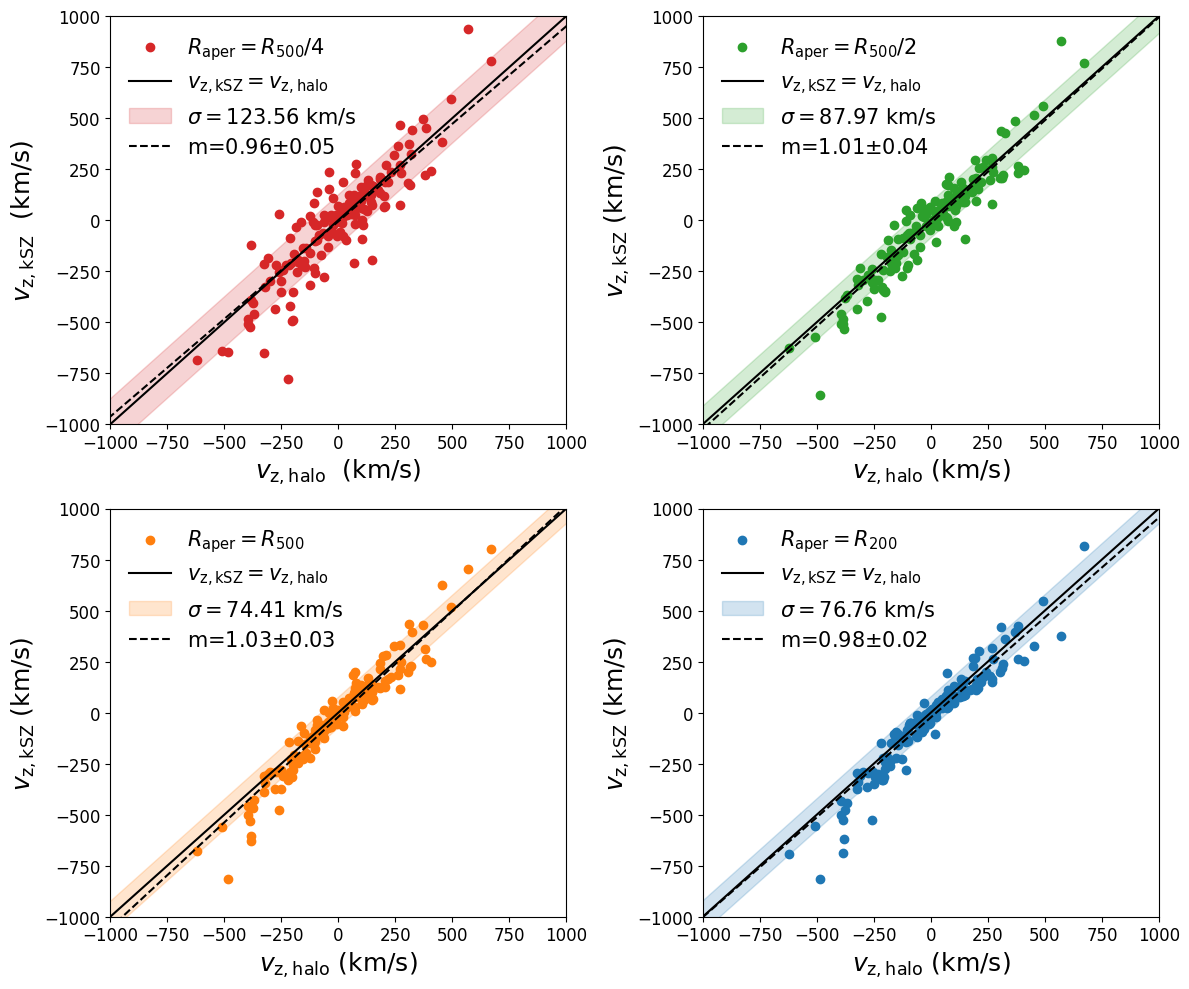

In [15]:
v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        v_true.append(result['vz_real'])
        v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
        v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
        v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])
        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_real'])
        vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_real'])
        vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_real'])
        vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_real'])

axis_lim = 1.8
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

mu, std = norm.fit(v_qr500_obs)
select = (np.array(v_qr500_obs)<=500)&(np.array(v_qr500_obs)>=-500)
residuals = np.array(v_qr500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][0].scatter(v_true,v_qr500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_true)[select],np.array(v_qr500_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$  (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$  (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major', labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
# axes[0][0].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][0].legend(fontsize=15,frameon=0,loc='upper left')

mu, std = norm.fit(v_half500_obs)
select = (np.array(v_half500_obs)<=500)&(np.array(v_half500_obs)>=-500)
residuals = np.array(v_half500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[0][1].scatter(v_true,v_half500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_true)[select],np.array(v_half500_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major', labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
# axes[0][1].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][1].legend(fontsize=15,frameon=0,loc='upper left')

mu, std = norm.fit(v_500_obs)
select = (np.array(v_500_obs)<=500)&(np.array(v_500_obs)>=-500)
residuals = np.array(v_500_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][0].scatter(v_true,v_500_obs,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_true)[select],np.array(v_500_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major', labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
# axes[1][0].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[1][0].legend(fontsize=15,frameon=0,loc='upper left')

mu, std = norm.fit(v_200_obs)
select = (np.array(v_200_obs)<=500)&(np.array(v_200_obs)>=-500)
residuals = np.array(v_200_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
axes[1][1].scatter(v_true,v_200_obs,label=r'$R_{\rm aper}=R_{\rm 200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label=r'$\sigma=$'+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_true)[select],np.array(v_200_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major', labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0,loc='upper left')
plt.tight_layout()
png_filename = 'vobs_vreal_polyfit_ex500_Tx_nop0.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
plt.savefig('vobs_vreal_ex500_Tx_nop0.png',dpi=450)

## median delta_vz

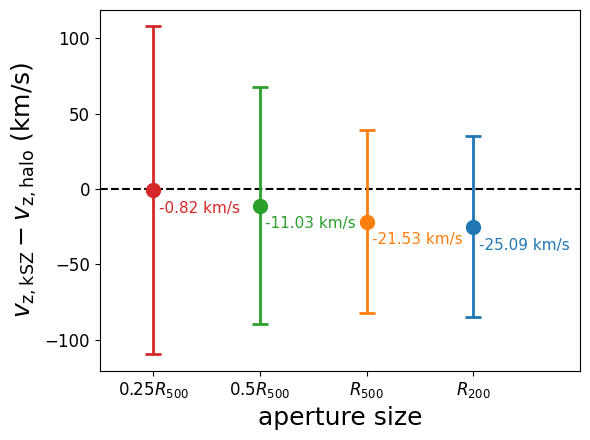

In [33]:
v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        v_true.append(result['vz_real'])
        v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
        v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
        v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])
        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_real'])
        vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_real'])
        vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_real'])
        vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_real'])

select = (np.array(v_qr500_obs)<=500)&(np.array(v_qr500_obs)>=-500)
v_qr500_dev = np.median(np.array(vdiff_qr500)[select])
v_qr500_dev_rms = np.sqrt(np.mean(np.array(vdiff_qr500)[select]**2))

select = (np.array(v_half500_obs)<=500)&(np.array(v_half500_obs)>=-500)
v_half500_dev = np.median(np.array(vdiff_half500)[select])
v_half500_dev_rms = np.sqrt(np.mean(np.array(vdiff_half500)[select]**2))

select = (np.array(v_500_obs)<=500)&(np.array(v_500_obs)>=-500)
v_500_dev = np.median(np.array(vdiff_500)[select])
v_500_dev_rms = np.sqrt(np.mean(np.array(vdiff_500)[select]**2))

select = (np.array(v_200_obs)<=500)&(np.array(v_200_obs)>=-500)
v_200_dev = np.median(np.array(vdiff_200)[select])
v_200_dev_rms = np.sqrt(np.mean(np.array(vdiff_200)[select]**2))
        
aper_size = [r'$0.25R_{\rm 500}$',r'$0.5R_{\rm 500}$',r'$R_{\rm 500}$',r'$R_{\rm 200}$']
dev = [v_qr500_dev,v_half500_dev,v_500_dev,v_200_dev]
dev_err = [v_qr500_dev_rms,v_half500_dev_rms,v_500_dev_rms,v_200_dev_rms]


plt.figure(figsize=(6,4.5))
plt.axhline(y=0.0, color='k', linestyle='--',lw=1.5)
plt.errorbar(aper_size[0],dev[0],yerr=dev_err[0],fmt='o',c='tab:red',ecolor='tab:red',capsize=6,markersize=10,elinewidth=2,capthick=2)
plt.errorbar(aper_size[1],dev[1],yerr=dev_err[1],fmt='o',c='tab:green',ecolor='tab:green',capsize=6, markersize=10, elinewidth=2,capthick=2)
plt.errorbar(aper_size[2],dev[2],yerr=dev_err[2],fmt='o',c='tab:orange',ecolor='tab:orange',capsize=6, markersize=10, elinewidth=2,capthick=2)
plt.errorbar(aper_size[3],dev[3],yerr=dev_err[3],fmt='o',c='tab:blue',ecolor='tab:blue',capsize=6, markersize=10, elinewidth=2,capthick=2)
plt.text(0.05,dev[0]-15,str(round(dev[0],2))+' km/s',fontsize=11,c='tab:red')
plt.text(1.05,dev[1]-15,str(round(dev[1],2))+' km/s',fontsize=11,c='tab:green')
plt.text(2.05,dev[2]-15,str(round(dev[2],2))+' km/s',fontsize=11,c='tab:orange')
plt.text(3.05,dev[3]-15,str(round(dev[3],2))+' km/s',fontsize=11,c='tab:blue')
plt.xlabel('aperture size',fontsize=18)
plt.ylabel(r'$v_{\rm z,kSZ}-v_{\rm z,halo}$ (km/s)',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.5, len(aper_size))
plt.tight_layout()
png_filename = 'vdiff_median_Tx.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
plt.savefig('vdiff_median_Tx_ex500.png',dpi=450)


## rms

### 30m

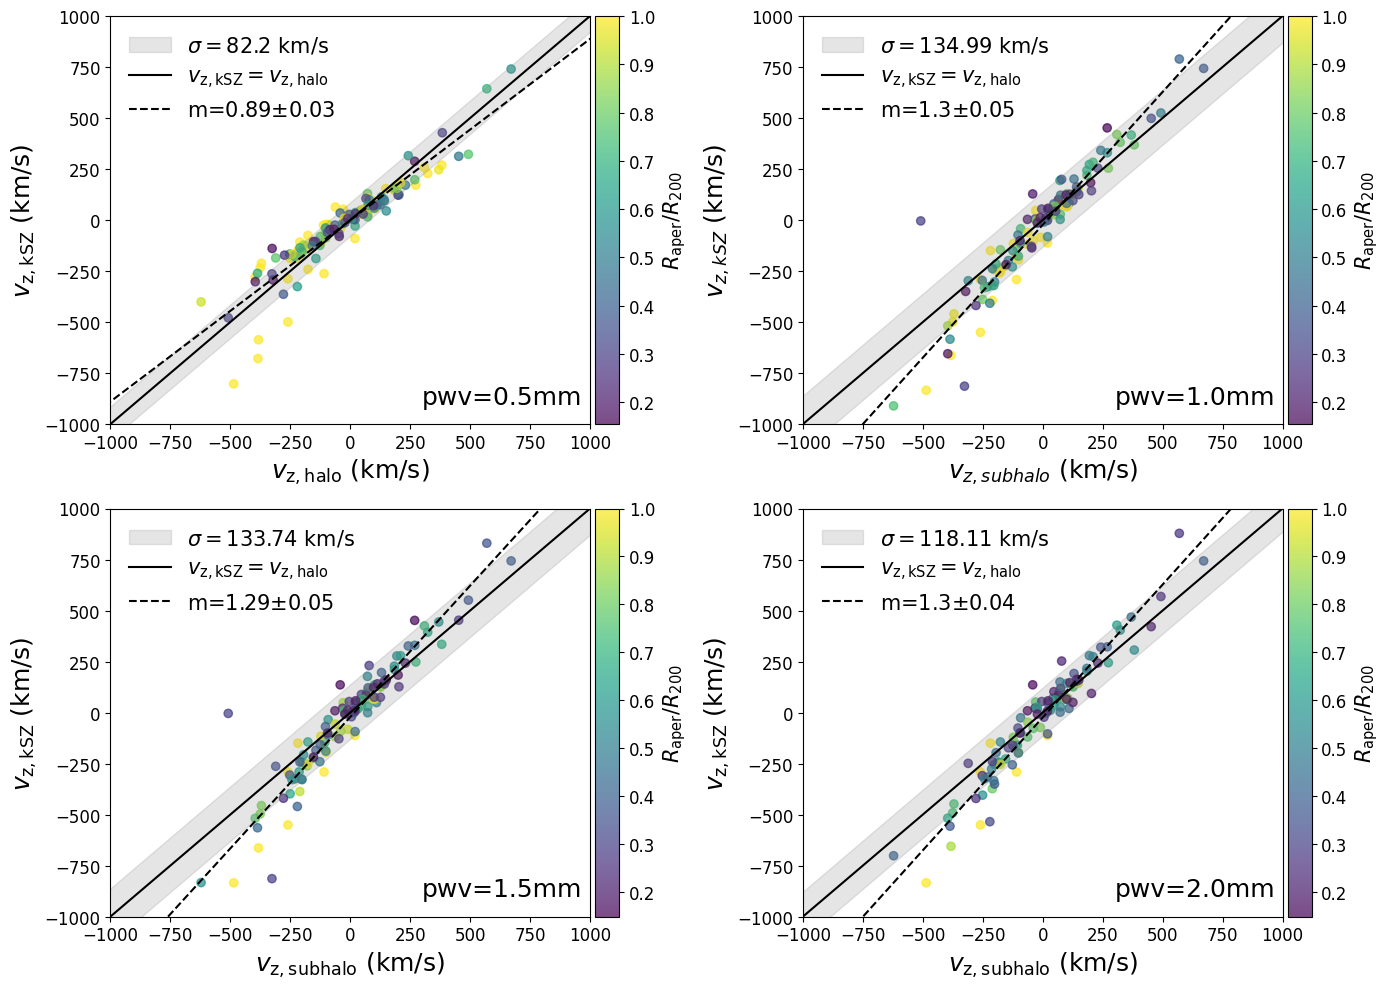

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][0]):
            R200 = result['R200']
            aper = result['apersize_detect'][0]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF_Tx'][0])
            v_rms_error.append(result['vz_obs_rms_err_CF_Tx'][0])
            vdiff_rms.append(result['vz_obs_rms_CF_Tx'][0]-result['vz_real'])
            

axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(v_true,v_rms_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)
axes[0][0].text(300,-900,'pwv=0.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][1]):
            R200 = result['R200']
            aper = result['apersize_detect'][1]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][1])
            v_rms_error.append(result['vz_obs_rms_err_CF'][1])
            vdiff_rms.append(result['vz_obs_rms_CF'][1]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(v_true,v_rms_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{z,subhalo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major',labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].legend(fontsize=15,frameon=0)
axes[0][1].text(300,-900,'pwv=1.0mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][2]):
            R200 = result['R200']
            aper = result['apersize_detect'][2]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][2])
            v_rms_error.append(result['vz_obs_rms_err_CF'][2])
            vdiff_rms.append(result['vz_obs_rms_CF'][2]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major',labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].legend(fontsize=15,frameon=0)
axes[1][0].text(300,-900,'pwv=1.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][3]):
            R200 = result['R200']
            aper = result['apersize_detect'][3]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][3])
            v_rms_error.append(result['vz_obs_rms_err_CF'][3])
            vdiff_rms.append(result['vz_obs_rms_CF'][3]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label = r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major',labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0)
axes[1][1].text(300,-900,'pwv=2.0mm',fontsize=18)

plt.tight_layout()
if os.path.exists('rms_pwv_30m.png'):
    os.remove('rms_pwv_30m.png')
plt.savefig('rms_pwv_30m.png',dpi=450)



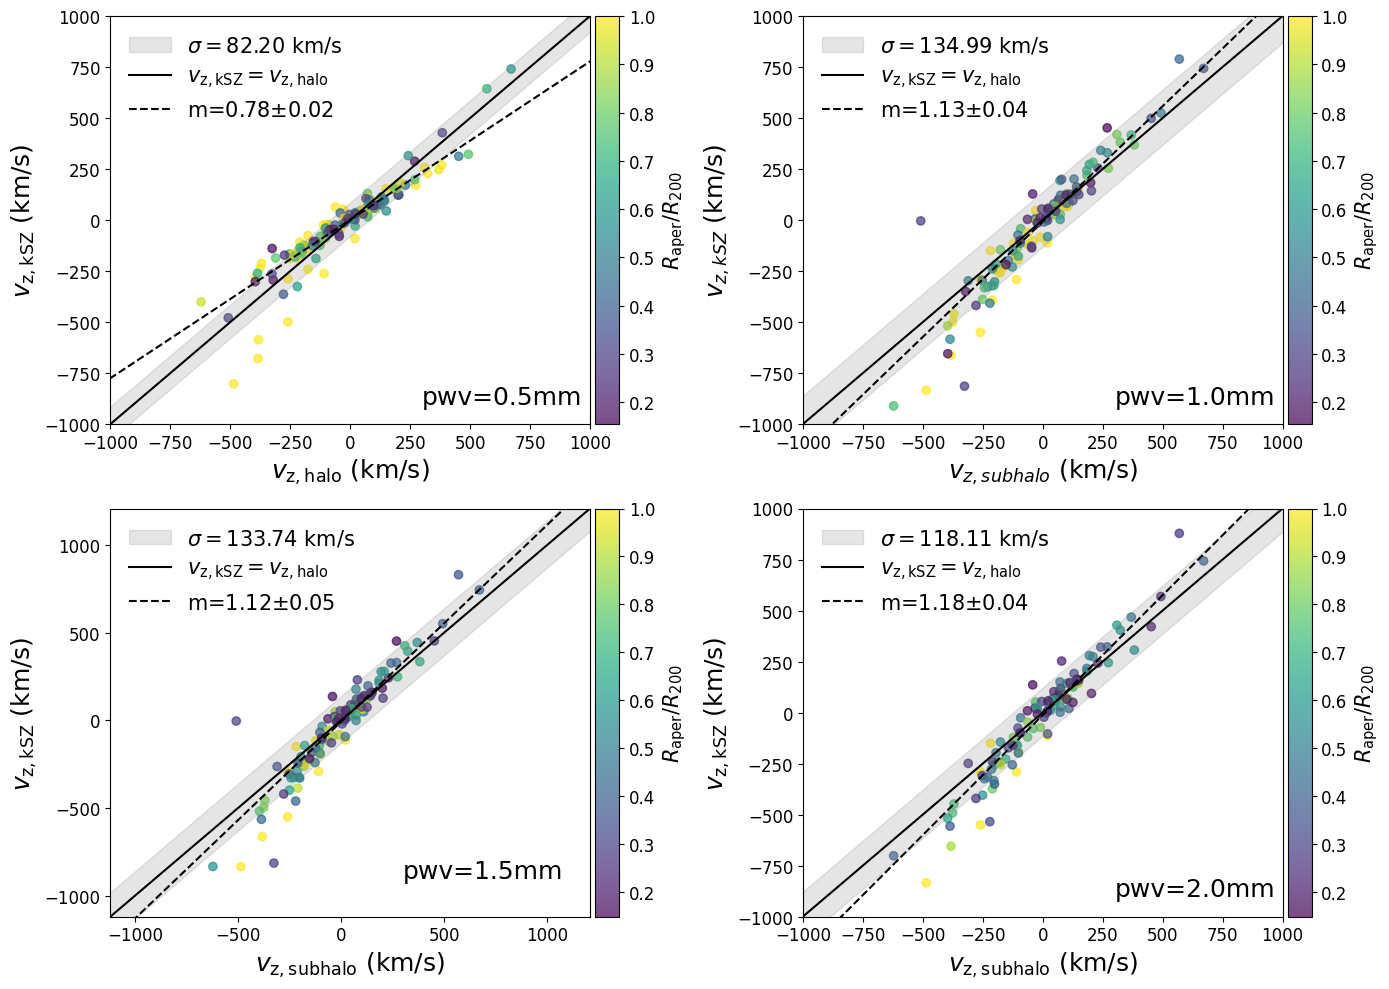

In [56]:
## exclude data points outside 500km/s

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][0]):
            R200 = result['R200']
            aper = result['apersize_detect'][0]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF_Tx'][0])
            v_rms_error.append(result['vz_obs_rms_err_CF_Tx'][0])
            vdiff_rms.append(result['vz_obs_rms_CF_Tx'][0]-result['vz_real'])
            

axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str("{:.2f}".format(std))+' km/s')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)
axes[0][0].text(300,-900,'pwv=0.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][1]):
            R200 = result['R200']
            aper = result['apersize_detect'][1]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][1])
            v_rms_error.append(result['vz_obs_rms_err_CF'][1])
            vdiff_rms.append(result['vz_obs_rms_CF'][1]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{z,subhalo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major',labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].legend(fontsize=15,frameon=0)
axes[0][1].text(300,-900,'pwv=1.0mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][2]):
            R200 = result['R200']
            aper = result['apersize_detect'][2]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][2])
            v_rms_error.append(result['vz_obs_rms_err_CF'][2])
            vdiff_rms.append(result['vz_obs_rms_CF'][2]-result['vz_real'])
            
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major',labelsize=12)
axes[1][0].set_ylim(np.min(v_true)*axis_lim,np.max(v_true)*axis_lim)
axes[1][0].set_xlim(np.min(v_true)*axis_lim,np.max(v_true)*axis_lim)
axes[1][0].legend(fontsize=15,frameon=0)
axes[1][0].text(300,-900,'pwv=1.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_30m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][3]):
            R200 = result['R200']
            aper = result['apersize_detect'][3]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][3])
            v_rms_error.append(result['vz_obs_rms_err_CF'][3])
            vdiff_rms.append(result['vz_obs_rms_CF'][3]-result['vz_real'])
            
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label = r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major',labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0)
axes[1][1].text(300,-900,'pwv=2.0mm',fontsize=18)

plt.tight_layout()
if os.path.exists('rms_pwv_30m_ex500.png'):
    os.remove('rms_pwv_30m_ex500.png')
plt.savefig('rms_pwv_30m_ex500.png',dpi=450)



### 10m

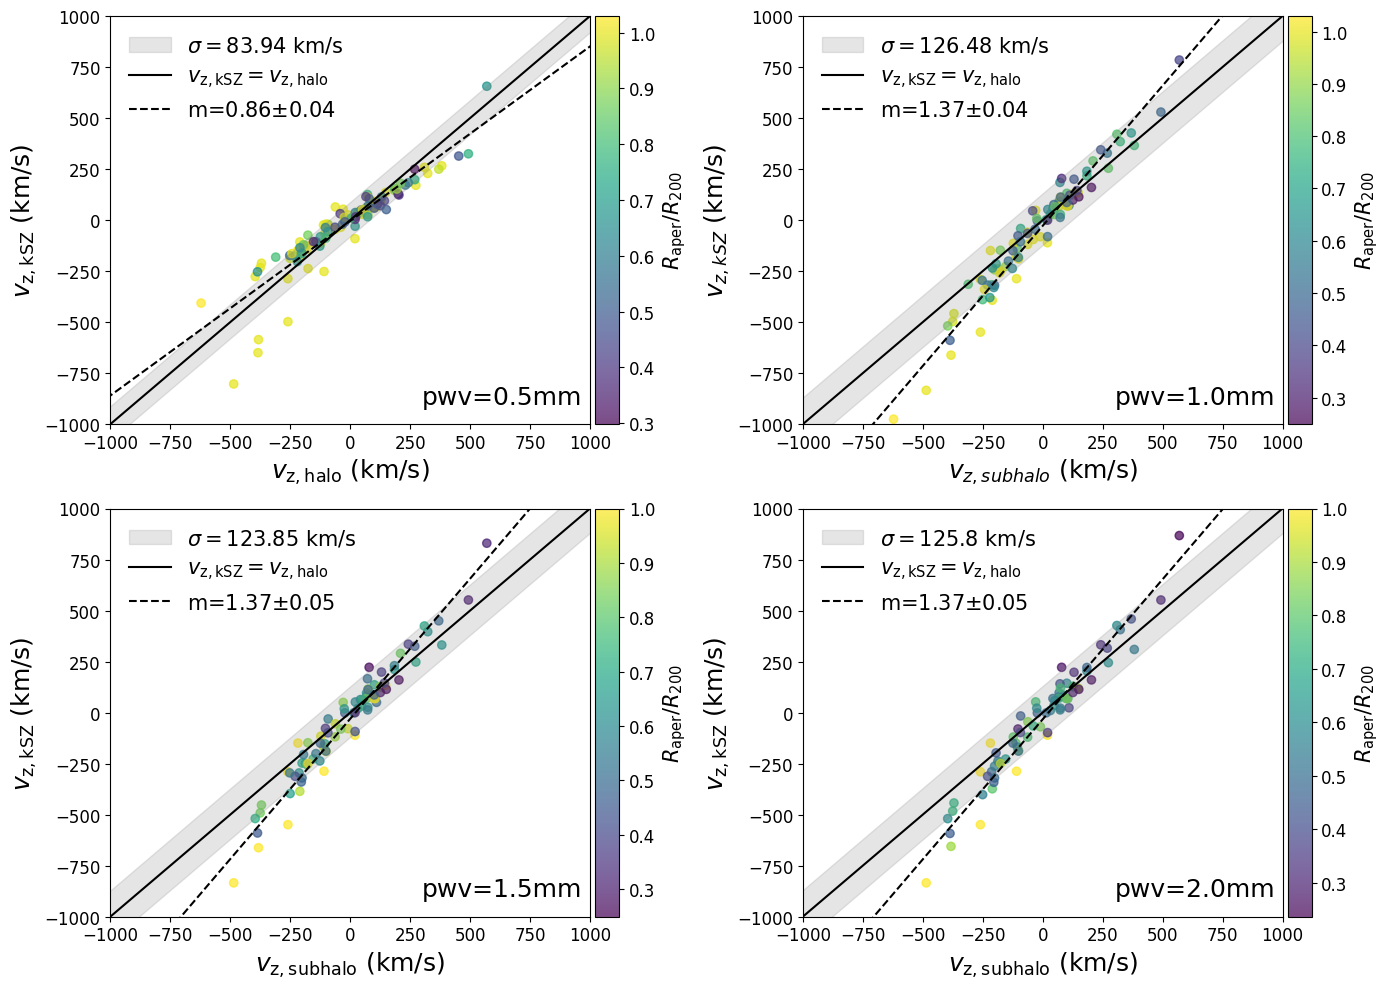

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][0]):
            R200 = result['R200']
            aper = result['apersize_detect'][0]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF_Tx'][0])
            v_rms_error.append(result['vz_obs_rms_err_CF_Tx'][0])
            vdiff_rms.append(result['vz_obs_rms_CF_Tx'][0]-result['vz_real'])
            

axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(v_true,v_rms_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)
axes[0][0].text(300,-900,'pwv=0.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][1]):
            R200 = result['R200']
            aper = result['apersize_detect'][1]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][1])
            v_rms_error.append(result['vz_obs_rms_err_CF'][1])
            vdiff_rms.append(result['vz_obs_rms_CF'][1]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(v_true,v_rms_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{z,subhalo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major',labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].legend(fontsize=15,frameon=0)
axes[0][1].text(300,-900,'pwv=1.0mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][2]):
            R200 = result['R200']
            aper = result['apersize_detect'][2]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][2])
            v_rms_error.append(result['vz_obs_rms_err_CF'][2])
            vdiff_rms.append(result['vz_obs_rms_CF'][2]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major',labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].legend(fontsize=15,frameon=0)
axes[1][0].text(300,-900,'pwv=1.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][3]):
            R200 = result['R200']
            aper = result['apersize_detect'][3]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][3])
            v_rms_error.append(result['vz_obs_rms_err_CF'][3])
            vdiff_rms.append(result['vz_obs_rms_CF'][3]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label = r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major',labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0)
axes[1][1].text(300,-900,'pwv=2.0mm',fontsize=18)

plt.tight_layout()
if os.path.exists('rms_pwv_10m.png'):
    os.remove('rms_pwv_10m.png')
plt.savefig('rms_pwv_10m.png',dpi=450)


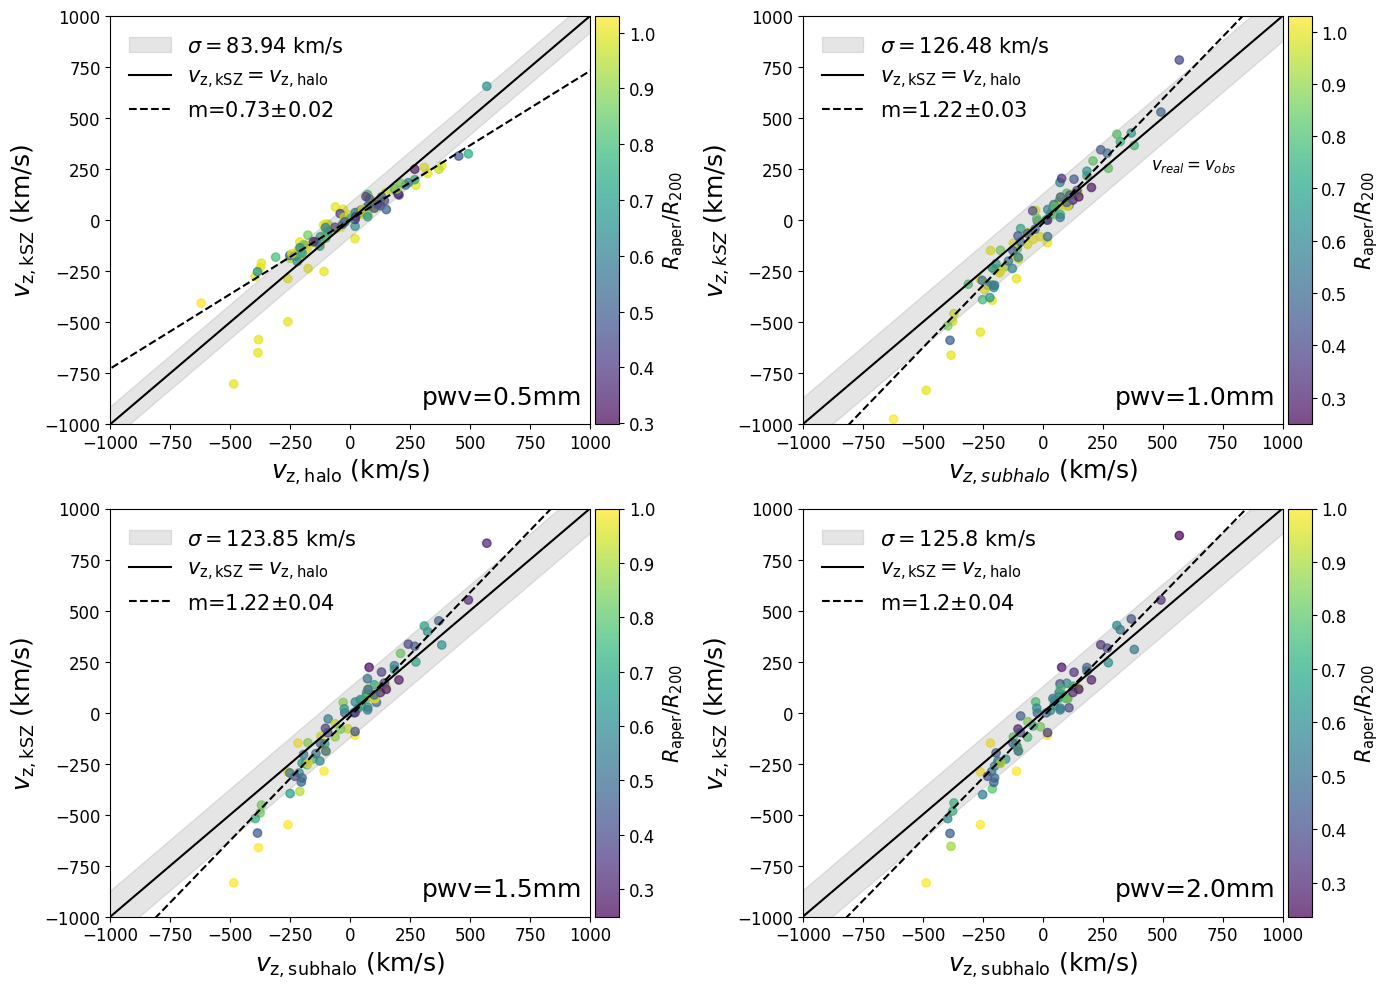

In [53]:
## exclude outsiders > 500km/s

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][0]):
            R200 = result['R200']
            aper = result['apersize_detect'][0]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF_Tx'][0])
            v_rms_error.append(result['vz_obs_rms_err_CF_Tx'][0])
            vdiff_rms.append(result['vz_obs_rms_CF_Tx'][0]-result['vz_real'])
            

residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)
axes[0][0].text(300,-900,'pwv=0.5mm',fontsize=18)

v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][1]):
            R200 = result['R200']
            aper = result['apersize_detect'][1]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][1])
            v_rms_error.append(result['vz_obs_rms_err_CF'][1])
            vdiff_rms.append(result['vz_obs_rms_CF'][1]-result['vz_real'])
            
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{z,subhalo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major',labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][1].legend(fontsize=15,frameon=0)
axes[0][1].text(300,-900,'pwv=1.0mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][2]):
            R200 = result['R200']
            aper = result['apersize_detect'][2]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][2])
            v_rms_error.append(result['vz_obs_rms_err_CF'][2])
            vdiff_rms.append(result['vz_obs_rms_CF'][2]-result['vz_real'])
            

residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major',labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].legend(fontsize=15,frameon=0)
axes[1][0].text(300,-900,'pwv=1.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_10m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][3]):
            R200 = result['R200']
            aper = result['apersize_detect'][3]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][3])
            v_rms_error.append(result['vz_obs_rms_err_CF'][3])
            vdiff_rms.append(result['vz_obs_rms_CF'][3]-result['vz_real'])
            

residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label = r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major',labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0)
axes[1][1].text(300,-900,'pwv=2.0mm',fontsize=18)

plt.tight_layout()
if os.path.exists('rms_pwv_10m_ex500.png'):
    os.remove('rms_pwv_10m_ex500.png')
plt.savefig('rms_pwv_10m_ex500.png',dpi=450)


### 100m

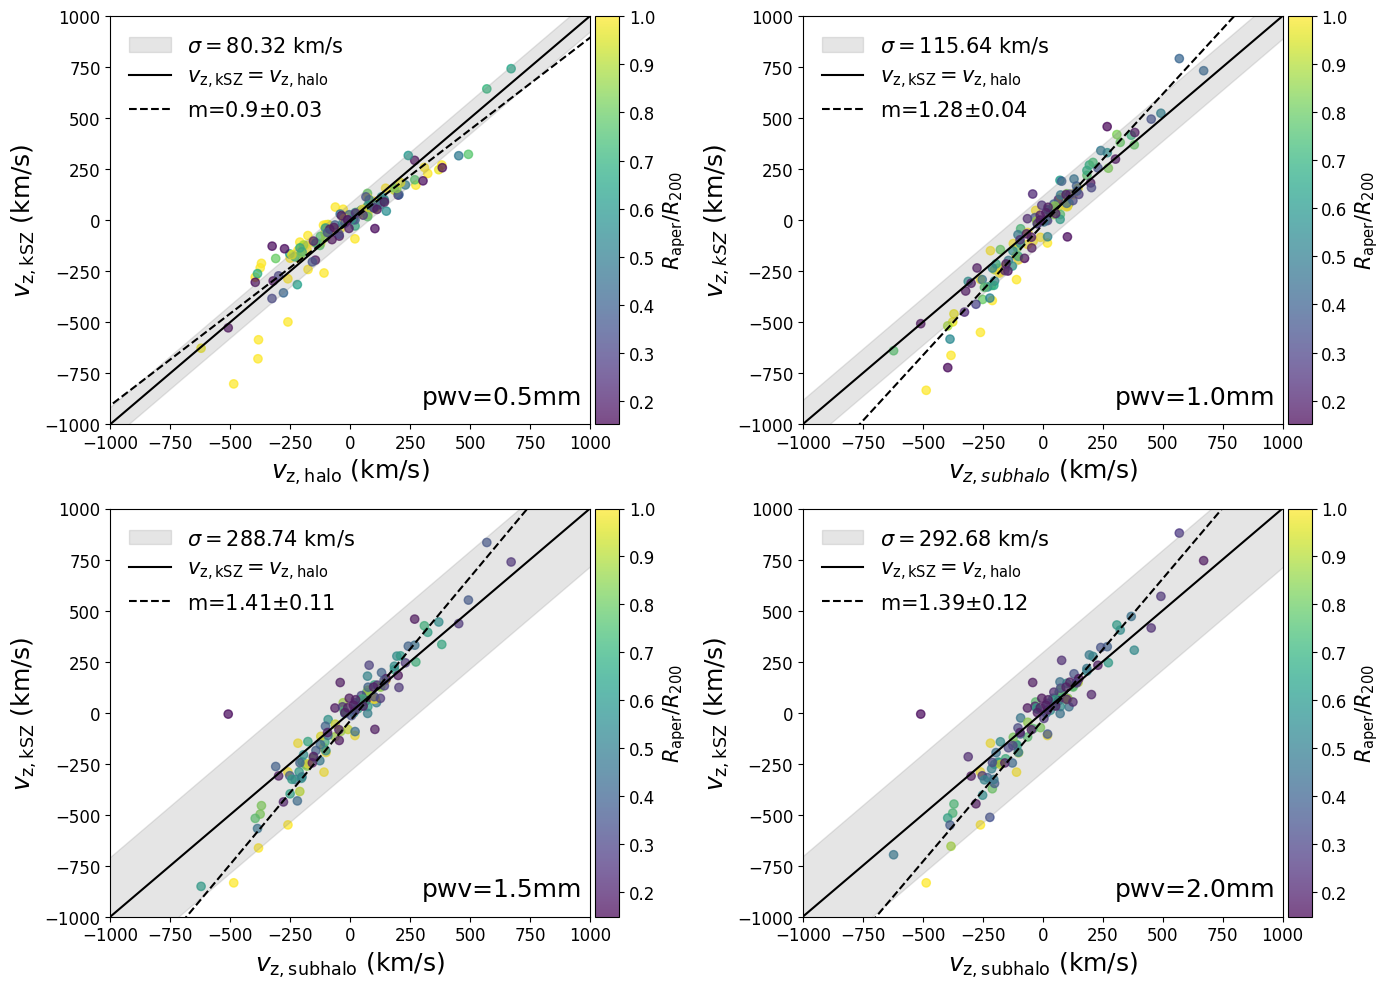

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][0]):
            R200 = result['R200']
            aper = result['apersize_detect'][0]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF_Tx'][0])
            v_rms_error.append(result['vz_obs_rms_err_CF_Tx'][0])
            vdiff_rms.append(result['vz_obs_rms_CF_Tx'][0]-result['vz_real'])
            

axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)
axes[0][0].text(300,-900,'pwv=0.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][1]):
            R200 = result['R200']
            aper = result['apersize_detect'][1]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][1])
            v_rms_error.append(result['vz_obs_rms_err_CF'][1])
            vdiff_rms.append(result['vz_obs_rms_CF'][1]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{z,subhalo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major',labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].legend(fontsize=15,frameon=0)
axes[0][1].text(300,-900,'pwv=1.0mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][2]):
            R200 = result['R200']
            aper = result['apersize_detect'][2]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][2])
            v_rms_error.append(result['vz_obs_rms_err_CF'][2])
            vdiff_rms.append(result['vz_obs_rms_CF'][2]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major',labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].legend(fontsize=15,frameon=0)
axes[1][0].text(300,-900,'pwv=1.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][3]):
            R200 = result['R200']
            aper = result['apersize_detect'][3]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][3])
            v_rms_error.append(result['vz_obs_rms_err_CF'][3])
            vdiff_rms.append(result['vz_obs_rms_CF'][3]-result['vz_real'])
            
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label = r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
popt, pcov = np.polyfit(np.array(v_true),np.array(v_rms_obs), 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major',labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0)
axes[1][1].text(300,-900,'pwv=2.0mm',fontsize=18)

plt.tight_layout()
if os.path.exists('rms_pwv_100m.png'):
    os.remove('rms_pwv_100m.png')
plt.savefig('rms_pwv_100m.png',dpi=450)

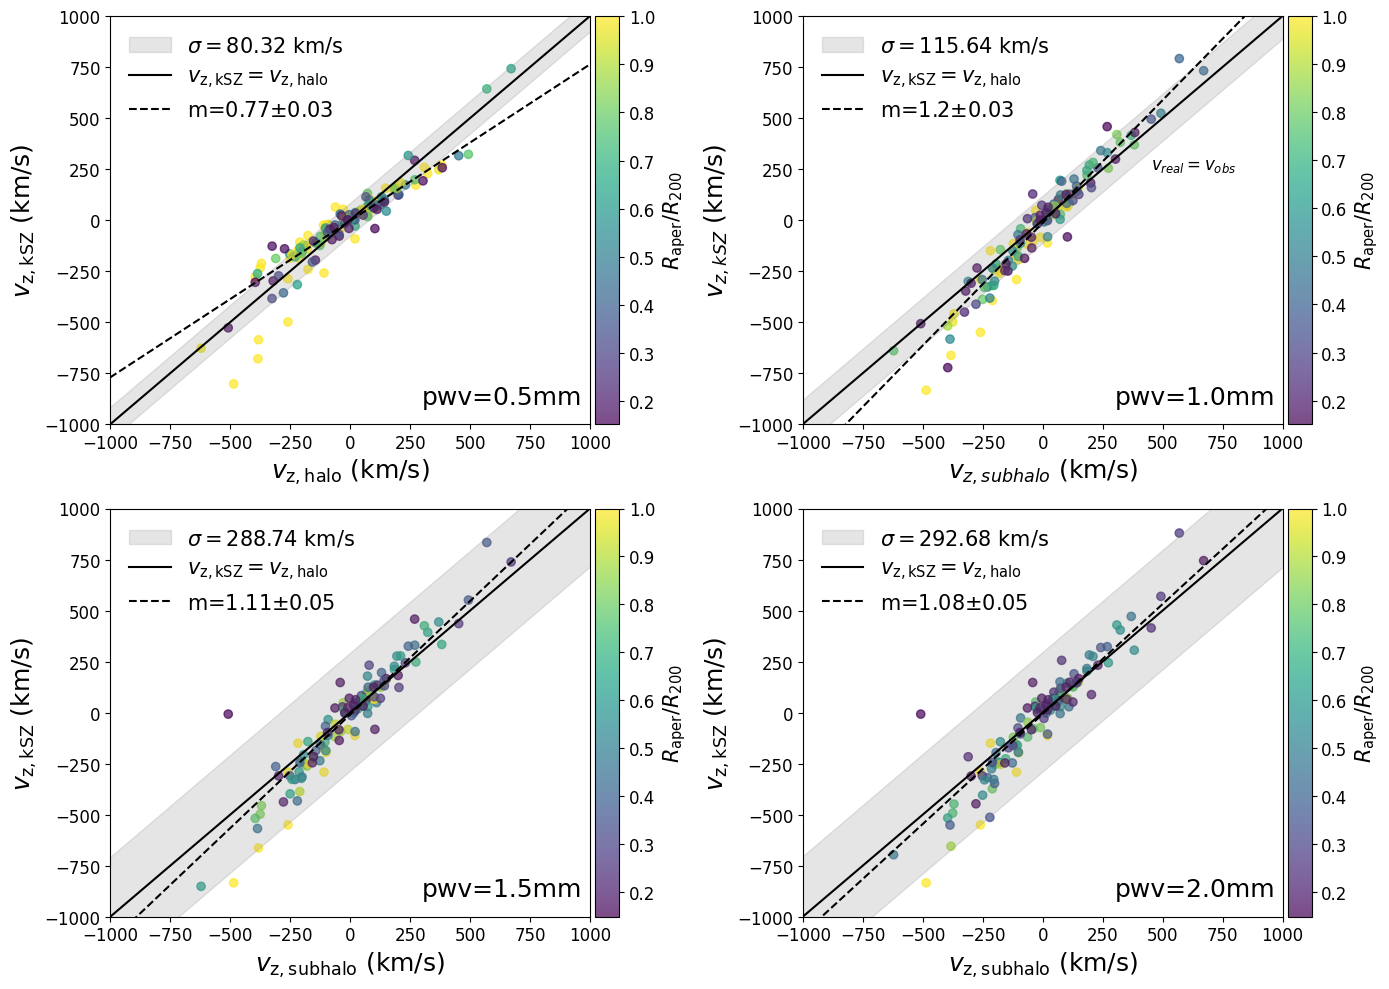

In [55]:
## exclude outsiders >500km/s

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][0]):
            R200 = result['R200']
            aper = result['apersize_detect'][0]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF_Tx'][0])
            v_rms_error.append(result['vz_obs_rms_err_CF_Tx'][0])
            vdiff_rms.append(result['vz_obs_rms_CF_Tx'][0]-result['vz_real'])
            

axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,halo}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].tick_params(axis='both', which='major',labelsize=12)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].legend(fontsize=15,frameon=0)
axes[0][0].text(300,-900,'pwv=0.5mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][1]):
            R200 = result['R200']
            aper = result['apersize_detect'][1]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][1])
            v_rms_error.append(result['vz_obs_rms_err_CF'][1])
            vdiff_rms.append(result['vz_obs_rms_CF'][1]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs) - np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[0][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{z,subhalo}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].tick_params(axis='both', which='major',labelsize=12)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].text(450,250,r'$v_{real}=v_{obs}$',fontsize=12)
axes[0][1].legend(fontsize=15,frameon=0)
axes[0][1].text(300,-900,'pwv=1.0mm',fontsize=18)


v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][2]):
            R200 = result['R200']
            aper = result['apersize_detect'][2]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][2])
            v_rms_error.append(result['vz_obs_rms_err_CF'][2])
            vdiff_rms.append(result['vz_obs_rms_CF'][2]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][0].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].tick_params(axis='both', which='major',labelsize=12)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].legend(fontsize=15,frameon=0)
axes[1][0].text(300,-900,'pwv=1.5mm',fontsize=18)

v_true = []
mass = []
v_rms_obs = []
v_rms_error = []
vdiff_rms = []
aper_size = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result_diff_telescope/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_pwv_100m.pkl','rb'))
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        if ~np.isnan(result['vz_obs_rms_CF'][3]):
            R200 = result['R200']
            aper = result['apersize_detect'][3]
            aper_size.append(aper/R200)
            v_true.append(result['vz_real'])
            mass.append(GC_gas['total_mass'])
            v_rms_obs.append(result['vz_obs_rms_CF'][3])
            v_rms_error.append(result['vz_obs_rms_err_CF'][3])
            vdiff_rms.append(result['vz_obs_rms_CF'][3]-result['vz_real'])
            
axis_lim = 1.8
residuals = np.array(v_rms_obs)-np.array(v_true)
std = np.sqrt(np.mean(residuals**2))
im = axes[1][1].scatter(v_true,v_rms_obs,c=np.array(aper_size),alpha=0.7)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label = r'$R_{\rm aper}/R_{\rm 200}$')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel(r'$R_{\rm aper}/R_{\rm 200}$', fontsize=15)
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='grey',label=r'$\sigma=$'+str(round(std,2))+' km/s')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,halo}$')
exclude_outiers = (np.array(v_rms_obs)>=-500) & (np.array(v_rms_obs)<=500)
popt, pcov = np.polyfit(np.array(v_true)[exclude_outiers],np.array(v_rms_obs)[exclude_outiers], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,subhalo}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].tick_params(axis='both', which='major',labelsize=12)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].legend(fontsize=15,frameon=0)
axes[1][1].text(300,-900,'pwv=2.0mm',fontsize=18)

plt.tight_layout()
if os.path.exists('rms_pwv_100m_ex500.png'):
    os.remove('rms_pwv_100m_ex500.png')
plt.savefig('rms_pwv_100m_ex500.png',dpi=450)



# v_{z,kSZ} vs. v_{z,gas}

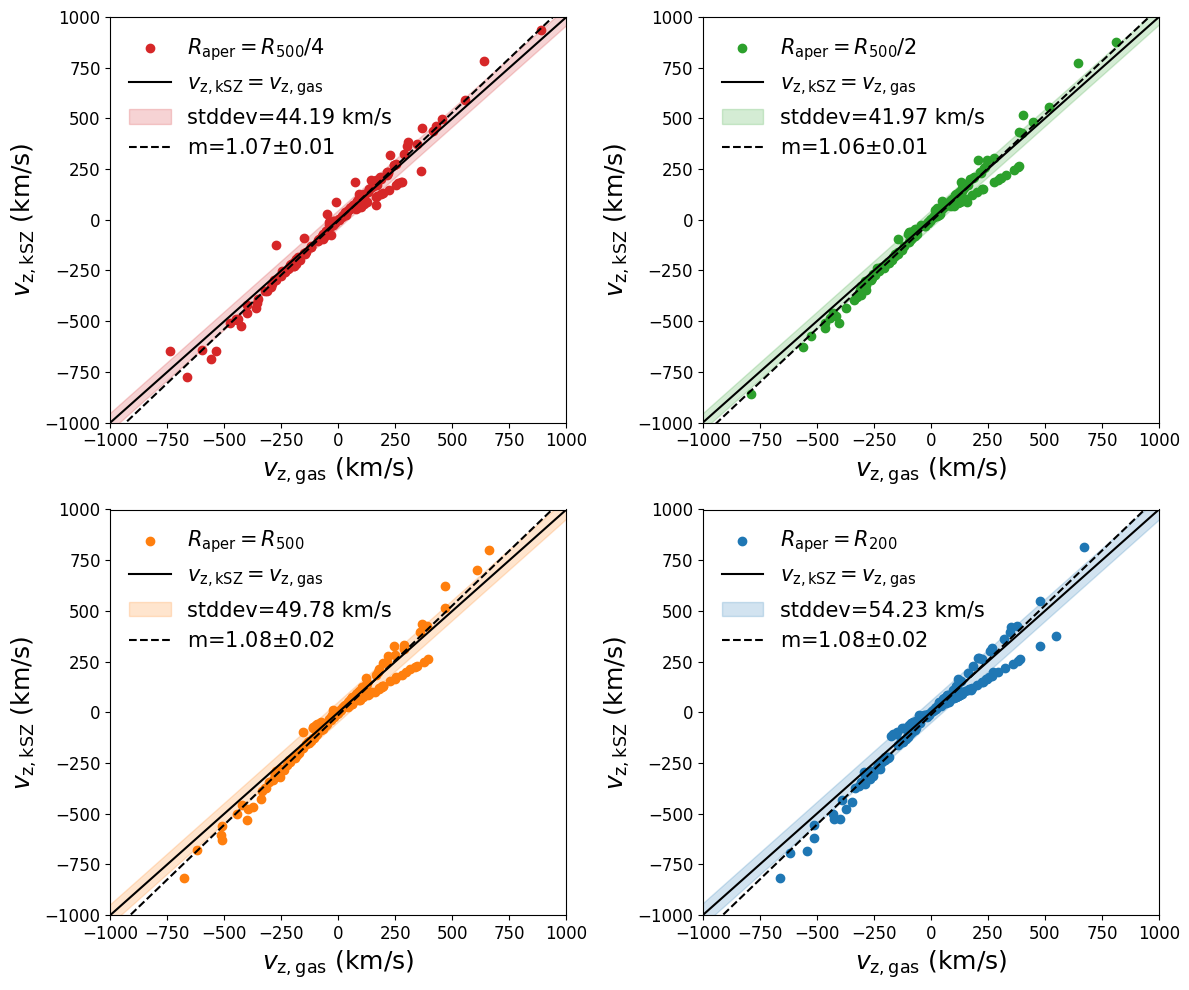

In [40]:
v_qr500_mass_weighted = []
v_half500_mass_weighted = []
v_500_mass_weighted = []
v_200_mass_weighted = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        v_qr500_mass_weighted.append(result['vz_mass_weighted'][0])
        v_half500_mass_weighted.append(result['vz_mass_weighted'][1])
        v_500_mass_weighted.append(result['vz_mass_weighted'][2])
        v_200_mass_weighted.append(result['vz_mass_weighted'][3])
        v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
        v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
        v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])
        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_mass_weighted'][0])
        vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_mass_weighted'][1])
        vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_mass_weighted'][2])
        vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_mass_weighted'][3])


axis_lim = 1.8
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

std = np.sqrt(np.mean(np.array(vdiff_qr500)**2))
axes[0][0].scatter(v_qr500_mass_weighted,v_qr500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label='stddev='+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_qr500_mass_weighted,v_qr500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].tick_params(axis='both',which='major',labelsize=12)
axes[0][0].legend(fontsize=15,frameon=0,loc='upper left')

std = np.sqrt(np.mean(np.array(vdiff_half500)**2))
axes[0][1].scatter(v_half500_mass_weighted,v_half500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label='stddev='+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_half500_mass_weighted,v_half500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].tick_params(axis='both',which='major',labelsize=12)
axes[0][1].legend(fontsize=15,frameon=0,loc='upper left')

std = np.sqrt(np.mean(np.array(vdiff_500)**2))
axes[1][0].scatter(v_500_mass_weighted,v_500_obs,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label='stddev='+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(v_500_mass_weighted,v_500_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].tick_params(axis='both',which='major',labelsize=12)
axes[1][0].legend(fontsize=15,frameon=0,loc='upper left')

std = np.sqrt(np.mean(np.array(vdiff_200)**2))
axes[1][1].scatter(v_200_mass_weighted,v_200_obs,label=r'$R_{\rm aper}=R_{\rm 200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label='stddev='+str(round(std,2))+' km/s')
m, b = np.polyfit(v_200_mass_weighted,v_200_obs, 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].tick_params(axis='both',which='major',labelsize=12)
axes[1][1].legend(fontsize=15,frameon=0,loc='upper left')
plt.tight_layout()
png_filename = 'vobs_vgas_Tx.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
plt.savefig('vobs_vgas_Tx_noex.png',dpi=450)

std_vdiff200 = round(std,2)

## exclude > 500 km/s

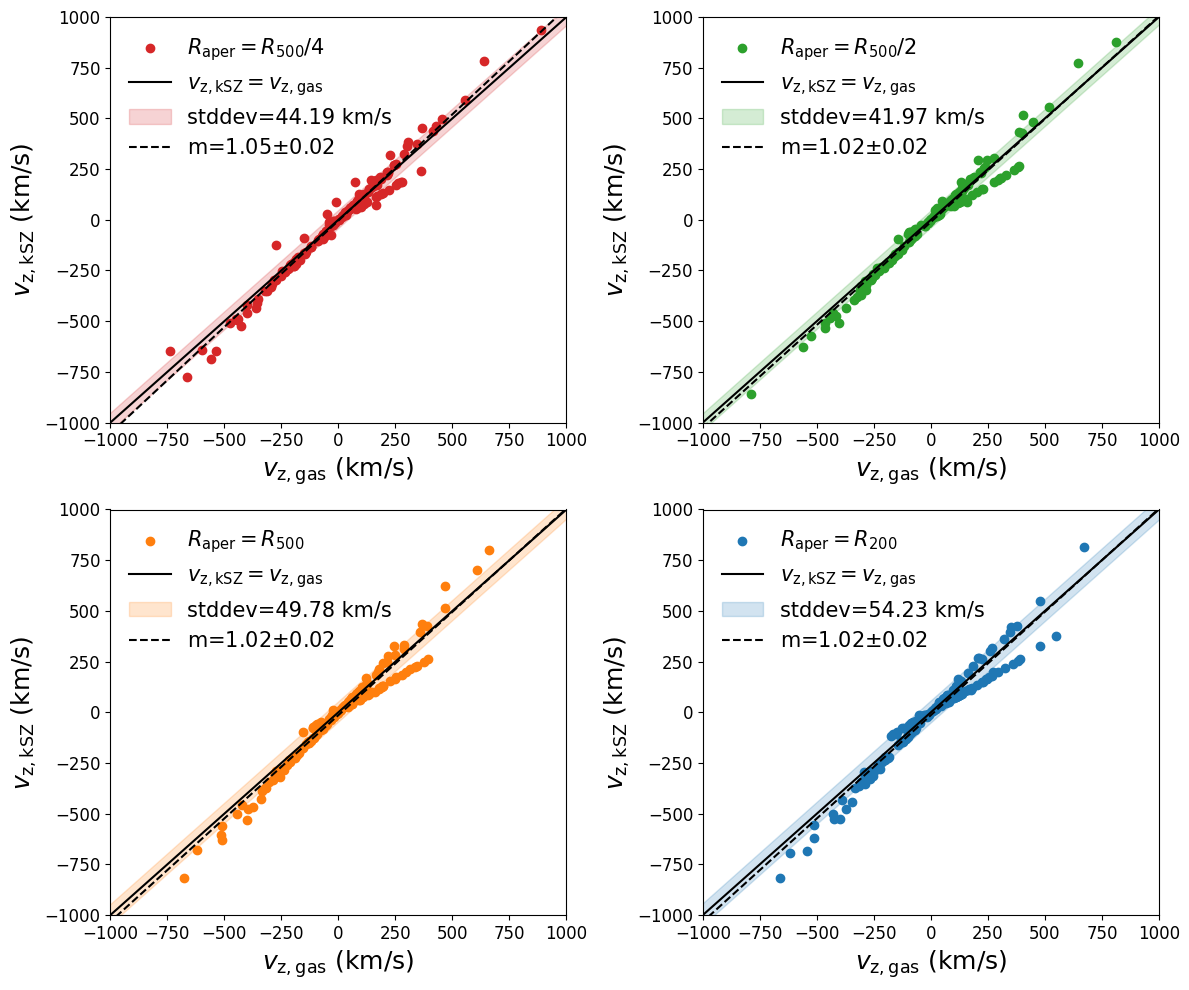

In [47]:
v_qr500_mass_weighted = []
v_half500_mass_weighted = []
v_500_mass_weighted = []
v_200_mass_weighted = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
fsh_mass = []
fsh_cell = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        v_qr500_mass_weighted.append(result['vz_mass_weighted'][0])
        v_half500_mass_weighted.append(result['vz_mass_weighted'][1])
        v_500_mass_weighted.append(result['vz_mass_weighted'][2])
        v_200_mass_weighted.append(result['vz_mass_weighted'][3])
        v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
        v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
        v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])
        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_mass_weighted'][0])
        vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_mass_weighted'][1])
        vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_mass_weighted'][2])
        vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_mass_weighted'][3])


axis_lim = 1.8
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

std = np.sqrt(np.mean(np.array(vdiff_qr500)**2))
select = (np.array(v_qr500_obs)<=500)&(np.array(v_qr500_obs)>=-500)
axes[0][0].scatter(v_qr500_mass_weighted,v_qr500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/4$',color='tab:red')
axes[0][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[0][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:red',label='stddev='+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_qr500_mass_weighted)[select],np.array(v_qr500_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][0].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][0].set_ylim(-1000,1000)
axes[0][0].set_xlim(-1000,1000)
axes[0][0].tick_params(axis='both',which='major',labelsize=12)
axes[0][0].legend(fontsize=15,frameon=0,loc='upper left')

std = np.sqrt(np.mean(np.array(vdiff_half500)**2))
select = (np.array(v_half500_obs)<=500)&(np.array(v_half500_obs)>=-500)
axes[0][1].scatter(v_half500_mass_weighted,v_half500_obs,label=r'$R_{\rm aper}=R_{\rm 500}/2$',color='tab:green')
axes[0][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[0][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:green',label='stddev='+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_half500_mass_weighted)[select],np.array(v_half500_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[0][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[0][1].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[0][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[0][1].set_ylim(-1000,1000)
axes[0][1].set_xlim(-1000,1000)
axes[0][1].tick_params(axis='both',which='major',labelsize=12)
axes[0][1].legend(fontsize=15,frameon=0,loc='upper left')

std = np.sqrt(np.mean(np.array(vdiff_500)**2))
select = (np.array(v_500_obs)<=500)&(np.array(v_500_obs)>=-500)
axes[1][0].scatter(v_500_mass_weighted,v_500_obs,label=r'$R_{\rm aper}=R_{\rm 500}$',color='tab:orange')
axes[1][0].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[1][0].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:orange',label='stddev='+str(round(std,2))+' km/s')
popt, pcov = np.polyfit(np.array(v_500_mass_weighted)[select],np.array(v_500_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][0].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][0].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][0].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][0].set_ylim(-1000,1000)
axes[1][0].set_xlim(-1000,1000)
axes[1][0].tick_params(axis='both',which='major',labelsize=12)
axes[1][0].legend(fontsize=15,frameon=0,loc='upper left')

std = np.sqrt(np.mean(np.array(vdiff_200)**2))
select = (np.array(v_200_obs)<=500)&(np.array(v_200_obs)>=-500)
axes[1][1].scatter(v_200_mass_weighted,v_200_obs,label=r'$R_{\rm aper}=R_{\rm 200}$',color='tab:blue')
axes[1][1].plot([-5000,5000],[-5000,5000],c='k',label=r'$v_{\rm z,kSZ}=v_{\rm z,gas}$')
axes[1][1].fill_between(np.array([-5000,5000]),np.array([-5000,5000])-std, np.array([-5000,5000])+std, alpha=0.2,color='tab:blue',label='stddev='+str(round(std,2))+' km/s')
m, b = np.polyfit(np.array(v_200_mass_weighted)[select],np.array(v_200_obs)[select], 1, cov=True)
m = popt[0]
b = popt[1]
m_err = np.sqrt(pcov[0][0])
b_err = np.sqrt(pcov[1][1])
axes[1][1].plot([-5000,5000],np.array([-5000,5000])*m+b,'k--',label='m='+str(round(m,2))+r'$\pm$'+str(round(m_err,2)))
axes[1][1].set_xlabel(r'$v_{\rm z,gas}$ (km/s)',fontsize=18)
axes[1][1].set_ylabel(r'$v_{\rm z,kSZ}$ (km/s)',fontsize=18)
axes[1][1].set_ylim(-1000,1000)
axes[1][1].set_xlim(-1000,1000)
axes[1][1].tick_params(axis='both',which='major',labelsize=12)
axes[1][1].legend(fontsize=15,frameon=0,loc='upper left')
plt.tight_layout()
png_filename = 'vobs_vgas_Tx_ex500.png'
if os.path.exists(png_filename):
    os.remove(png_filename)
plt.savefig('vobs_vgas_Tx_ex500.png',dpi=450)

# std_vdiff200 = round(std,2)

## outliers for vgas-vksz

In [24]:
outliers = []
residuals = np.array(v_qr500_obs) - np.array(v_qr500_mass_weighted)
std = np.std(residuals)
for i in range(0,len(residuals)):
    if np.abs(residuals[i])>3*std:
        outliers.append([i//50+1,(i+1)%50])
residuals = np.array(v_half500_obs) - np.array(v_half500_mass_weighted)
std = np.std(residuals)
for i in range(0,len(residuals)):
    if np.abs(residuals[i])>3*std:
        outliers.append([i//50+1,(i+1)%50])
residuals = np.array(v_500_obs) - np.array(v_500_mass_weighted)
std = np.std(residuals)
for i in range(0,len(residuals)):
    if np.abs(residuals[i])>3*std:
        outliers.append([i//50+1,(i+1)%50])
residuals = np.array(v_200_obs) - np.array(v_200_mass_weighted)
std = np.std(residuals)
for i in range(0,len(residuals)):
    if np.abs(residuals[i])>3*std:
        outliers.append([i//50+1,(i+1)%50])
# outliers

mass_range  1 ,  1 th source
mass_range  1 ,  40 th source
mass_range  2 ,  16 th source
mass_range  2 ,  36 th source
mass_range  3 ,  29 th source
mass_range  4 ,  2 th source
mass_range  4 ,  5 th source


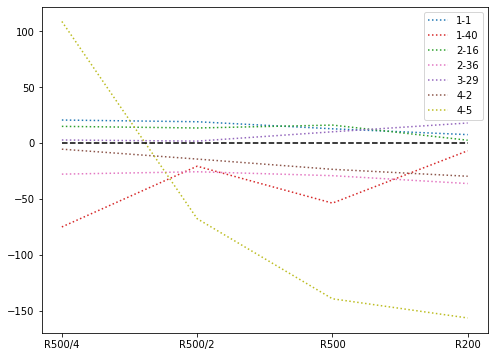

In [25]:
outliers = [[1, 1],[1, 40],[2, 16],[2, 36],[3, 29],[4, 2],[4, 5]]
marker=['.','*','^','s']
aper_size = ['R500/4','R500/2','R500','R200']
source_colors = ['tab:blue','tab:red','tab:green','tab:pink','tab:purple','tab:brown','tab:olive','tab:cyan']
plt.figure(figsize=(8,6))
for j in range(0,len(outliers)):
    print('mass_range ',str(outliers[j][0]),', ', str(outliers[j][1]),'th source')
    result = pickle.load(open(current_path+'/data3/result/mass_range'+str(outliers[j][0])+'/TNG300-3_'+str(outliers[j][1])+'th_result.pkl','rb'))
    v_true = result['vz_real']
    v_qr500_obs = result['vz_obs_pure_CF'][0]
    v_half500_obs = result['vz_obs_pure_CF'][1]
    v_500_obs = result['vz_obs_pure_CF'][2]
    v_200_obs = result['vz_obs_pure_CF'][3]
    v_qr500_gas = result['vz_mass_weighted'][0]
    v_half500_gas = result['vz_mass_weighted'][1]
    v_500_gas = result['vz_mass_weighted'][2]
    v_200_gas = result['vz_mass_weighted'][3]
    delta_v_gas = [v_qr500_obs-v_qr500_gas,v_half500_obs-v_half500_gas,v_500_obs-v_500_gas,v_200_obs-v_200_gas]
    plt.plot(aper_size,delta_v_gas,linestyle='dotted',color=source_colors[j],label=str(outliers[j][0])+'-'+str(outliers[j][1]))
plt.plot(aper_size,[0,0,0,0],'k--')
plt.legend()

# delta_v vs. concentration

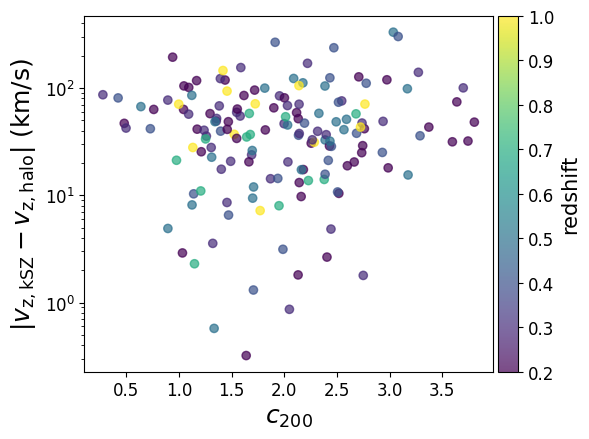

In [62]:
v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
v_qr500_gas = []
v_half500_gas = []
v_500_gas = []
v_200_gas = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
c200 = []
M200 = []
redshift = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
            v_true.append(result['vz_real'])
            v_qr500_gas.append(result['vz_mass_weighted'][0])
            v_half500_gas.append(result['vz_mass_weighted'][1])
            v_500_gas.append(result['vz_mass_weighted'][2])
            v_200_gas.append(result['vz_mass_weighted'][3])
            v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
            v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
            v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])
            v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
            vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_real'])
            vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_real'])
            vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_real'])
            vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_real'])
            c200.append(result['c200'])
            M200.append(result['log_M200_Msun'])
            redshift.append(result['redshift'])

# plt.figure(figsize=(6,4))
# plt.scatter(c200,np.abs(np.array(vdiff_200)))
# plt.xlabel('c200',fontsize=15)
# plt.ylabel(r'$\Delta v_z\ (km/s)$',fontsize=15)
# plt.yscale('log')
# plt.savefig('concentration.png')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))
im = axes.scatter(c200,np.abs(np.array(vdiff_200)),c=redshift,alpha=0.7)
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label='redshift')
colorbar.ax.set_ylabel('redshift', fontsize=15)
colorbar.ax.tick_params(labelsize=12)
axes.set_xlabel(r'$c_{\rm 200}$',fontsize=18)
# axes.axhline(y = std_vdiff200,linestyle = '--',color='k',label=r'standard deviation of the difference between $v_{\rm z,kSZ}$ and $v_{\rm z,gas}$')
axes.set_ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=18)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.set_yscale('log')
plt.tight_layout()
if os.path.exists('concentration_Tx.png'):
    os.remove('concentration_Tx.png')
plt.savefig('concentration_Tx.png',dpi=450)

# vdiff_200 = np.array(v_200_gas)-np.array(v_true)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
# im = axes.scatter(c200,np.abs(np.array(vdiff_200)),c=M200,alpha=1)
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical',label='M200')
# axes.set_xlabel('c200',fontsize=15)
# # axes.set_ylabel(r'$\Delta v_z\ (km/s)$',fontsize=15)
# axes.set_ylabel(r'$v_{z,gas}-v_{z,halo}$ (km/s)',fontsize=15)
# axes.set_yscale('log')
# plt.tight_layout()
# plt.savefig('concentration_gas.png',overwrite=True,dpi=450)



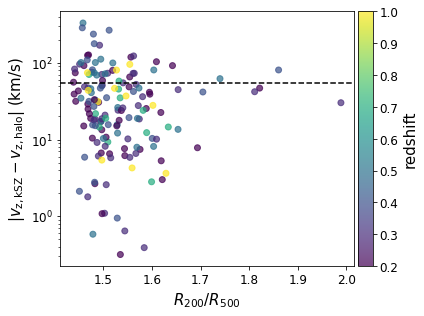

In [70]:
v_true = []
v_200_obs = []
v_200_gas = []
vdiff_200 = []
c200 = []
M200 = []
R200_R500 = []
redshift = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        if i not in []:
            result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
            v_true.append(result['vz_real'])
            v_200_gas.append(result['vz_mass_weighted'][3])
            v_200_obs.append(result['vz_obs_pure_CF'][3])
            vdiff_200.append(result['vz_obs_pure_CF'][3]-result['vz_real'])
            c200.append(result['c200'])
            M200.append(result['log_M200_Msun'])
            redshift.append(result['redshift'])
            R200_R500.append(result['R200']/result['R500'])

# vdiff_200 = np.array(v_200_gas)-np.array(v_true)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))
im = axes.scatter(R200_R500,np.abs(np.array(vdiff_200)),c=redshift,alpha=0.7)
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label='redshift')
colorbar.ax.set_ylabel('redshift', fontsize=15)
colorbar.ax.tick_params(labelsize=12)
axes.axhline(y = std_vdiff200,linestyle = '--',color='k',label=r'standard deviation of the difference between $v_{\rm z,kSZ}$ and $v_{\rm z,gas}$')
axes.set_xlabel(r'$R_{200}/R_{500}$',fontsize=15)
axes.set_ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=15)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.set_yscale('log')
# axes.set_xscale('log')
plt.tight_layout()
plt.savefig('concentration_r200r500_Tx.png',overwrite=True,dpi=450)

# AGN feedback

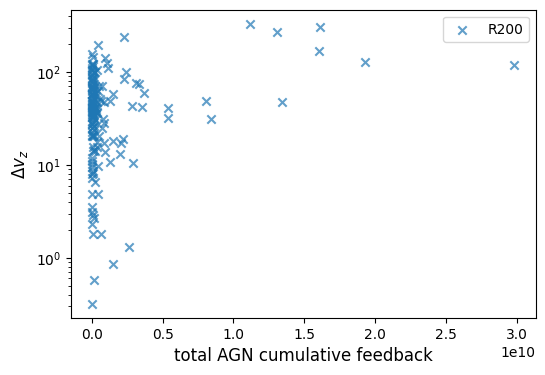

In [63]:
v_true = []
v_200_obs = []
v_200_gas = []
nonthAGN_200 = []
thAGN_200 = []
Mhalo = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        R200 = result['R200']
        R500 = result['R500']
        R200_arcsec = result['R200_arcsec']
        R500_arcsec = result['R500_arcsec']
        M200 = result['log_M200_Msun'] 
        M500 = result['log_M500_Msun']
#         aperture_limit = np.max(result['resolution'])
        v_true.append(result['vz_real'])
        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        v_200_gas.append(result['vz_mass_weighted'][3])
        Mhalo.append(M200) # in log( Msun)
        
        BH_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_BH.pkl'
        GC_BH = pickle.load(open(BH_file,'rb'))
        dx = GC_BH['dx']
        dy = GC_BH['dy']
        nonthAGN = GC_BH['AGN_nonth_fb'] # in 10^10 Msun*(kpc/Gyr)^2
        thAGN = GC_BH['AGN_th_fb'] # in 10^10 Msun*(kpc/Gyr)^2
        rr = np.sqrt((dx)**2+(dy)**2)
        ww=np.where(rr<=R200)
        thAGN_200.append(np.sum(thAGN[ww]))
        nonthAGN_200.append(np.sum(nonthAGN[ww]))
        
            
ALPHA = 0.7

# plt.figure(figsize=(6,4))
# plt.scatter(nonthAGN_qr500,np.abs(np.array(vdiff_qr500)),label='R500/4', alpha=ALPHA, marker='s')
# plt.scatter(nonthAGN_half500,np.abs(np.array(vdiff_half500)),label='R500/2', alpha=ALPHA, marker='o')
# plt.scatter(nonthAGN_500,np.abs(np.array(vdiff_500)),label='R500', alpha=ALPHA, marker='^')
# plt.scatter(nonthAGN_200,np.abs(np.array(vdiff_200)),label='R200', alpha=ALPHA, marker='x')
# plt.xlabel('AGN non-thermal cumulative feedback',fontsize=12)
# plt.ylabel(r'$\Delta v_z$',fontsize=12)
# plt.yscale('log')
# plt.legend()

# plt.figure(figsize=(6,4))
# plt.scatter(thAGN_qr500,np.abs(np.array(vdiff_qr500)),label='R500/4', alpha=ALPHA, marker='s')
# plt.scatter(thAGN_half500,np.abs(np.array(vdiff_half500)),label='R500/2', alpha=ALPHA, marker='o')
# plt.scatter(thAGN_500,np.abs(np.array(vdiff_500)),label='R500', alpha=ALPHA, marker='^')
# plt.scatter(thAGN_200,np.abs(np.array(vdiff_200)),label='R200', alpha=ALPHA, marker='x')
# plt.xlabel('AGN thermal cumulative feedback',fontsize=12)
# plt.ylabel(r'$\Delta v_z$',fontsize=12)
# plt.yscale('log')
# plt.legend()

vdiff_200 = np.abs(np.array(v_200_obs)-np.array(v_true))
plt.figure(figsize=(6,4))
# plt.scatter(np.array(thAGN_qr500)+np.array(nonthAGN_qr500),np.abs(np.array(vdiff_qr500)),label='R500/4', alpha=ALPHA, marker='s')
# plt.scatter(np.array(thAGN_half500)+np.array(nonthAGN_half500),np.abs(np.array(vdiff_half500)),label='R500/2', alpha=ALPHA, marker='o')
# plt.scatter(np.array(thAGN_500)+np.array(nonthAGN_500),np.abs(np.array(vdiff_500)),label='R500', alpha=ALPHA, marker='^')
plt.scatter(np.array(thAGN_200)+np.array(nonthAGN_200),vdiff_200,label='R200', alpha=ALPHA, marker='x')
plt.xlabel('total AGN cumulative feedback',fontsize=12)
plt.ylabel(r'$\Delta v_z$',fontsize=12)
plt.yscale('log')
plt.legend()


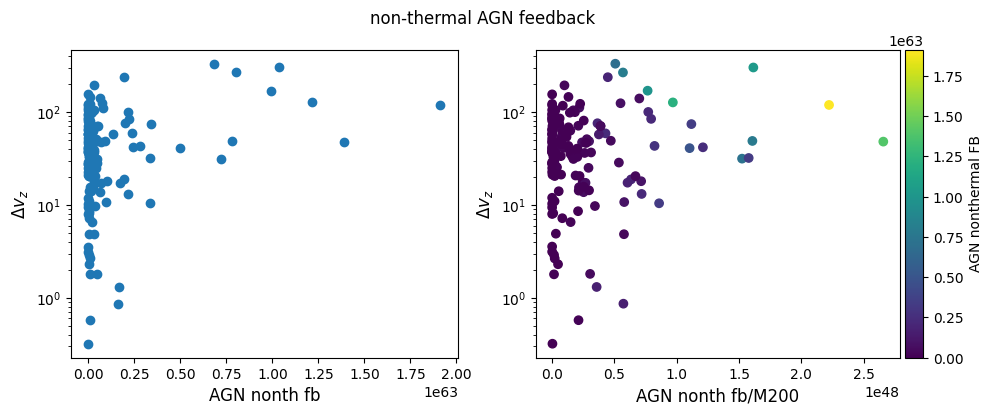

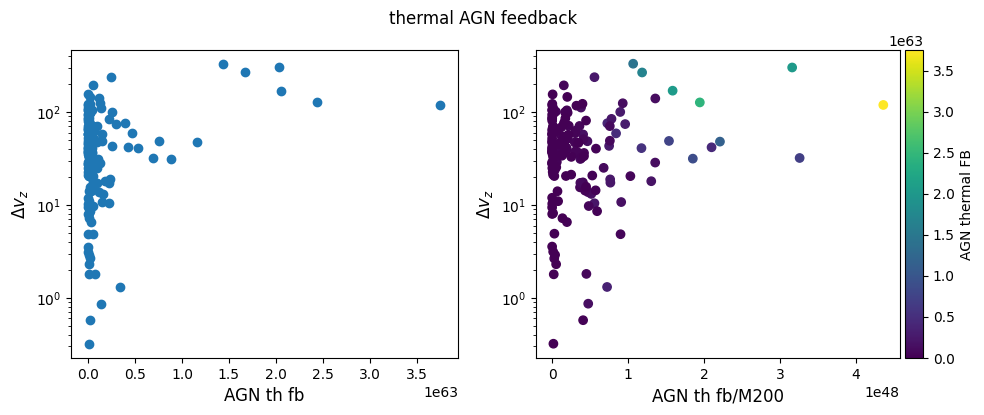

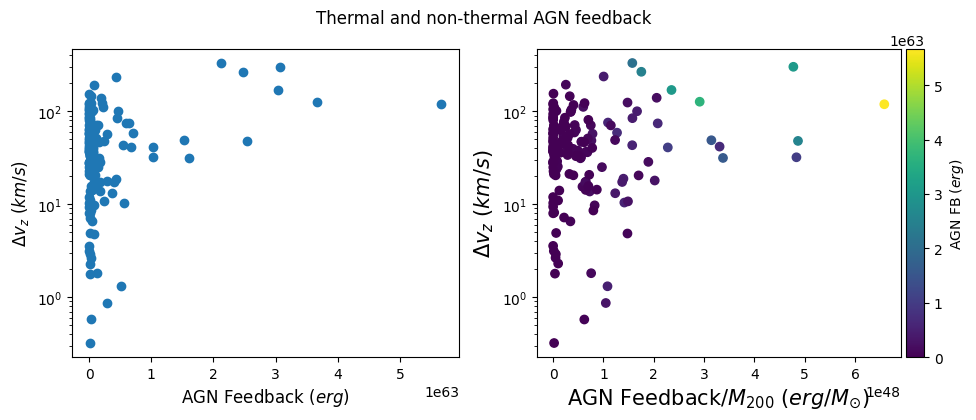

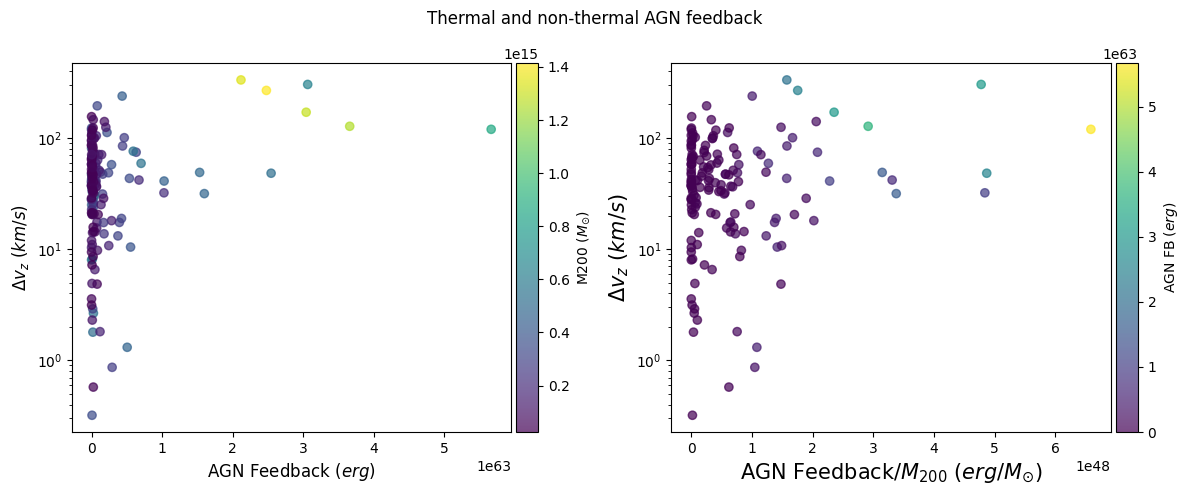

In [64]:
# convert from 10^10 Msun*kpc^2/Gyr^2 to erg
convert_to_erg = (10**10*u.solMass*u.kpc*u.kpc/u.Gyr/u.Gyr).to(u.erg).value
vdiff_200 = np.abs(np.array(v_200_obs)-np.array(v_true))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
axes[0].scatter(np.array(nonthAGN_200)*convert_to_erg,np.abs(np.array(vdiff_200)))
axes[0].set_xlabel('AGN nonth fb',fontsize=12)
axes[0].set_ylabel(r'$\Delta v_z$',fontsize=12)
axes[0].set_yscale('log')

xdata = np.array(nonthAGN_200)*convert_to_erg/10**np.array(Mhalo)
im = axes[1].scatter(xdata,np.abs(np.array(vdiff_200)),label='AGN_nonth_FB/M_h',c=np.array(nonthAGN_200)*convert_to_erg)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label='AGN nonthermal FB')
axes[1].set_xlabel('AGN nonth fb/M200',fontsize=12)
axes[1].set_ylabel(r'$\Delta v_z$',fontsize=12)
axes[1].set_yscale('log')

fig.suptitle('non-thermal AGN feedback')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
axes[0].scatter(np.array(thAGN_200)*convert_to_erg,np.abs(np.array(vdiff_200)))
axes[0].set_xlabel('AGN th fb',fontsize=12)
axes[0].set_ylabel(r'$\Delta v_z$',fontsize=12)
axes[0].set_yscale('log')

xdata = np.array(thAGN_200)*convert_to_erg/10**np.array(Mhalo)
im = axes[1].scatter(xdata,np.abs(np.array(vdiff_200)),label='AGN_th_FB/M_h',c=np.array(thAGN_200)*convert_to_erg)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label='AGN thermal FB')
axes[1].set_xlabel('AGN th fb/M200',fontsize=12)
axes[1].set_ylabel(r'$\Delta v_z$',fontsize=12)
axes[1].set_yscale('log')

fig.suptitle('thermal AGN feedback')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
axes[0].scatter((np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg,np.abs(np.array(vdiff_200)))
axes[0].set_xlabel(r'${\rm AGN\ Feedback}\ (erg)$',fontsize=12)
axes[0].set_ylabel(r'$\Delta v_z\ (km/s)$',fontsize=12)
axes[0].set_yscale('log')

xdata = (np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg/10**np.array(Mhalo)
im = axes[1].scatter(xdata,np.abs(np.array(vdiff_200)),label='AGN_FB/M_h',c=(np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=r'AGN FB $(erg)$')
axes[1].set_xlabel(r'${\rm AGN\ Feedback}/M_{200}\ (erg/M_{\odot})$',fontsize=15)
axes[1].set_ylabel(r'$\Delta v_z\ (km/s)$',fontsize=15)
axes[1].set_yscale('log')

fig.suptitle('Thermal and non-thermal AGN feedback')
# plt.savefig('AGN_FB.png')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
im = axes[0].scatter((np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg,np.abs(np.array(vdiff_200)),label='AGN_FB/M_h',c=10**np.array(Mhalo),alpha=0.7)
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=r'M200 $(M_{\odot})$')
axes[0].set_xlabel(r'${\rm AGN\ Feedback}\ (erg)$',fontsize=12)
axes[0].set_ylabel(r'$\Delta v_z\ (km/s)$',fontsize=12)
axes[0].set_yscale('log')

xdata = (np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg/10**np.array(Mhalo)
im = axes[1].scatter(xdata,np.abs(np.array(vdiff_200)),label='AGN_FB/M_h',c=(np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg,alpha=0.7)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical',label=r'AGN FB $(erg)$')
axes[1].set_xlabel(r'${\rm AGN\ Feedback}/M_{200}\ (erg/M_{\odot})$',fontsize=15)
axes[1].set_ylabel(r'$\Delta v_z\ (km/s)$',fontsize=15)
axes[1].set_yscale('log')

fig.suptitle('Thermal and non-thermal AGN feedback')
plt.tight_layout()



## AGN/M200 vs. (v_{z,kSZ}-v_{z,halo})

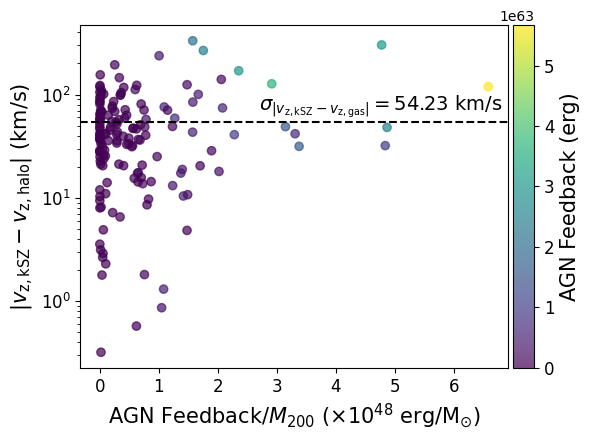

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))
vdiff_200 = np.abs(np.array(v_200_obs)-np.array(v_true))
xdata = (np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg/10**np.array(Mhalo)/1e48
im = axes.scatter(xdata,np.array(vdiff_200),label='AGN_FB/M_h',c=(np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg,alpha=0.7)
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(im, cax=cax, orientation='vertical',label=r'AGN FB (erg)')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel('AGN Feedback (erg)', fontsize=15)
axes.axhline(y = std_vdiff200,linestyle = '--',color='k',label=r'standard deviation of the difference between $v_{\rm z,kSZ}$ and $v_{\rm z,gas}$')
axes.text(2.7,70,r'$\sigma_{|v_{\rm z,kSZ}-v_{\rm z,gas}|}=$'+str(round(std_vdiff200,2))+' km/s',fontsize=14)
axes.set_xlabel(r'AGN Feedback/$M_{\rm 200}$ ($\times 10^{48}$ erg/$\rm M_{\odot}$)',fontsize=15)
axes.set_ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=15)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.set_yscale('log')
plt.tight_layout()
if os.path.exists('AGN_FB_Tx.png'):
    os.remove('AGN_FB_Tx.png')
plt.savefig('AGN_FB_Tx.png',dpi=450)

In [67]:
xdata = (np.array(thAGN_200)+np.array(nonthAGN_200))*convert_to_erg/10**np.array(Mhalo)
high_AGNfb_id = []
high_AGNfb = []
high_AGNfb_vobs = []
high_AGNfb_vtrue = []
high_AGNfb_vgas = []
high_AGNfb_Mhalo = []
for i in range(0,len(xdata)):
    if xdata[i]>2.5e48:
        high_AGNfb_id.append([i//50+1,(i+1)%50])
        high_AGNfb_vobs.append(v_200_obs[i])
        high_AGNfb_vtrue.append(v_true[i])
        high_AGNfb_vgas.append(v_200_gas[i])
        high_AGNfb_Mhalo.append(Mhalo[i])
        high_AGNfb.append((thAGN_200[i]+nonthAGN_200[i])*convert_to_erg/10**Mhalo[i])       
high_AGNfb_id

[[1, 1], [1, 13], [1, 16], [1, 24], [1, 29], [1, 40], [2, 15], [2, 16]]

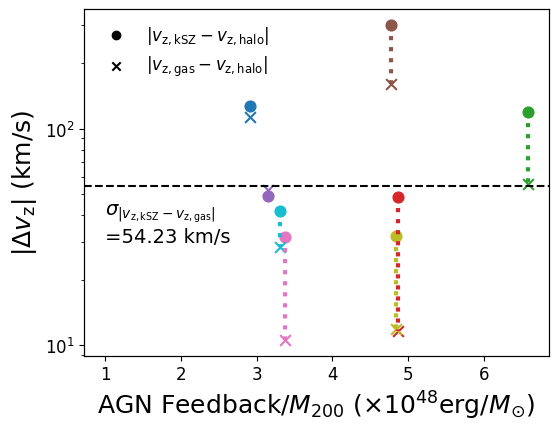

In [81]:
source_colors = ['tab:blue','tab:red','tab:green','tab:pink','tab:purple','tab:brown','tab:olive','tab:cyan']
fig, ax = plt.subplots(figsize=(6,4.5))
for j in range(0,len(high_AGNfb)):
    delta_v = np.abs(high_AGNfb_vobs[j]-high_AGNfb_vtrue[j])
    delta_v_gas = np.abs(high_AGNfb_vgas[j]-high_AGNfb_vtrue[j])
    xdata = high_AGNfb[j]/1e48
    # ,label='mass_range '+str(high_AGNfb_id[j][0])+'-'+str(high_AGNfb_id[j][1])
    ax.scatter(xdata,delta_v,color=source_colors[j],s=60)
    ax.scatter(xdata,delta_v_gas,color=source_colors[j],marker='x',s=60)
    ax.plot([xdata,xdata],[delta_v,delta_v_gas],color=source_colors[j],linestyle='dotted',lw=3)
ax.plot([1,2.5],[0,0],'k--')
ax.axhline(y = std_vdiff200,linestyle = '--',color='k',label=r'standard deviation of the difference between $v_{\rm z,kSZ}$ and $v_{\rm z,gas}$')
ax.text(1.0,30,r'$\sigma_{|v_{\rm z,kSZ}-v_{\rm z,gas}|}$'+'\n='+str(round(std_vdiff200,2))+' km/s',fontsize=14)
ax.set_yscale('log')
ax.set_xlabel(r'AGN Feedback/$M_{\rm 200}$ ($\times 10^{48}$erg/$M\rm _{\odot}$)',fontsize=18)
# ax.set_ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=15)
ax.set_ylabel(r'$|\Delta v_{\rm z}|$ (km/s)',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

ax2 = ax.twinx()
ax2.scatter(np.NaN, np.NaN, marker='o',label=r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$', c='black')
ax2.scatter(np.NaN, np.NaN, marker='x',label=r'$|v_{\rm z,gas}-v_{\rm z,halo}|$', c='black')
ax2.get_yaxis().set_visible(False)

# ax.legend(loc='upper left',fontsize=12)
ax2.legend(loc='upper left',fontsize=12,frameon=False)
if os.path.exists('AGN_FB_comparison_Tx.png'):
    os.remove('AGN_FB_comparison_Tx.png')
plt.savefig('AGN_FB_comparison_Tx.png',dpi=450)
plt.show()


# SFR feedback

## SFR vs. (v_{z,kSZ}-v_{z,halo})

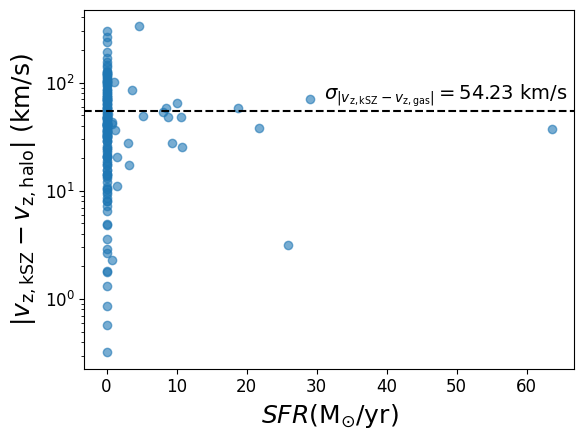

In [70]:
v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
SFR_qr500 = []
SFR_half500 = []
SFR_500 = []
SFR_200 = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        R200 = result['R200']
        R500 = result['R500']
        R200_arcsec = result['R200_arcsec']
        R500_arcsec = result['R500_arcsec']
#         aperture_limit = np.max(result['resolution'])
        v_true.append(result['vz_real'])
        
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        dx = GC_gas['dx']
        dy = GC_gas['dy']
        SFR = GC_gas['SFR']
        rr = np.sqrt((dx)**2+(dy)**2)

        v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
        vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_real'])
        ww=np.where(rr<=R500/4)
        SFR_qr500.append(np.sum(SFR[ww]))

        v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
        vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_real'])
        ww=np.where(rr<=R500/2)
        SFR_half500.append(np.sum(SFR[ww]))

        v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])            
        vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_real'])
        ww=np.where(rr<=R500)
        SFR_500.append(np.sum(SFR[ww]))

        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_real'])
        ww=np.where(rr<=R200)
        SFR_200.append(np.sum(SFR[ww]))


ALPHA = 0.6
plt.figure(figsize=(6,4.5))
# plt.scatter(SFR_qr500,np.abs(np.array(vdiff_qr500)),label='R500/4', alpha=ALPHA, marker='s',fc='white',ec='tab:green')
# plt.scatter(SFR_half500,np.abs(np.array(vdiff_half500)),label='R500/2', alpha=ALPHA, marker='^',fc='white',ec='tab:orange')
# plt.scatter(SFR_500,np.abs(np.array(vdiff_500)),label='R500', alpha=ALPHA, marker='x',fc='white',ec='tab:red')
plt.scatter(SFR_200,np.abs(np.array(vdiff_200)),label='R200', alpha=ALPHA, marker='o',ec='tab:blue')
plt.axhline(y = std_vdiff200,linestyle = '--',color='k',label=r'standard deviation of the difference between $v_{\rm z,kSZ}$ and $v_{\rm z,gas}$')
plt.text(31,70,r'$\sigma_{|v_{\rm z,kSZ}-v_{\rm z,gas}|}=$'+str(round(std_vdiff200,2))+' km/s',fontsize=14)
plt.xlabel(r'$SFR {\rm (M_{\odot}/yr)}$',fontsize=18)
plt.ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.tight_layout()

if os.path.exists('stellar_FB_Tx.png'):
    os.remove('stellar_FB_Tx.png')
plt.savefig('stellar_FB_Tx.png',dpi=450)



# Total Mass

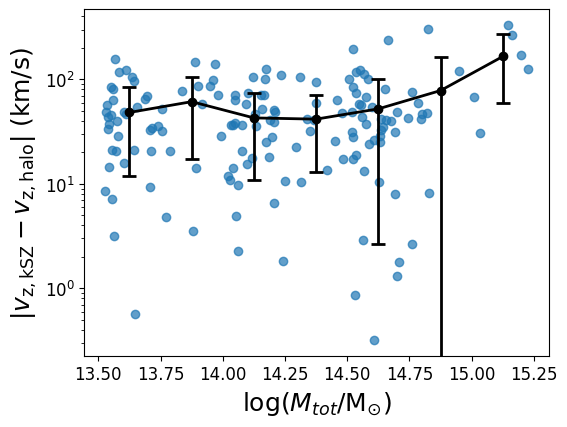

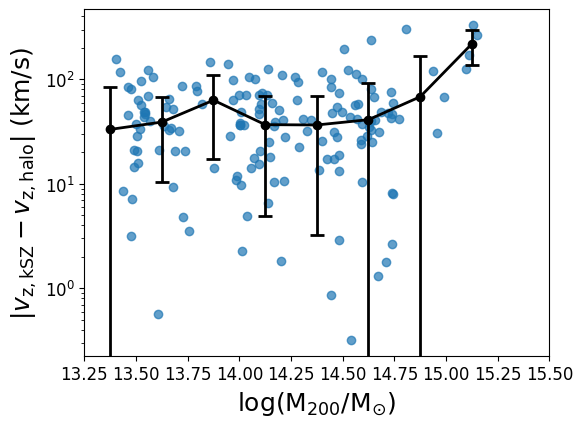

In [84]:
from scipy.stats import norm

v_true = []
v_qr500_obs = []
v_half500_obs = []
v_500_obs = []
v_200_obs = []
vdiff_qr500 = []
vdiff_half500 = []
vdiff_500 = []
vdiff_200 = []
total_mass = []
M200 = []
for mass_range in [4,3,2,1]:
    if mass_range == 4:
        source_range = 6
    else:
        source_range = 51
    for i in range(1,source_range):
        result = pickle.load(open(current_path+'/data3/result/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_result_Tx.pkl','rb'))
        v_true.append(result['vz_real'])
        M200.append(result['log_M200_Msun'])
        
        gas_file = current_path+'/data3/sample/mass_range'+str(mass_range)+'/TNG300-3_'+str(i)+'th_gas.pkl'
        GC_gas = pickle.load(open(gas_file,'rb'))
        dx = GC_gas['dx']
        dy = GC_gas['dy']
        total_mass.append(GC_gas['total_mass'])
        v_qr500_obs.append(result['vz_obs_pure_CF_nop0'][0])
        vdiff_qr500.append(result['vz_obs_pure_CF_nop0'][0]-result['vz_real'])

        v_half500_obs.append(result['vz_obs_pure_CF_nop0'][1])
        vdiff_half500.append(result['vz_obs_pure_CF_nop0'][1]-result['vz_real'])

        v_500_obs.append(result['vz_obs_pure_CF_nop0'][2])            
        vdiff_500.append(result['vz_obs_pure_CF_nop0'][2]-result['vz_real'])

        v_200_obs.append(result['vz_obs_pure_CF_nop0'][3])
        vdiff_200.append(result['vz_obs_pure_CF_nop0'][3]-result['vz_real'])


mass_medium = []
delta_vz = []
delta_vz_err = []
for i in range(0,7):
    mass_min = 13.5+i*0.25
    mass_max = 13.5+(1+i)*0.25
    mass_medium.append((mass_min+mass_max)/2)
    ww = np.where((np.array(total_mass)>mass_min) & (np.array(total_mass)<mass_max))
    vz = np.abs(np.array(vdiff_200)[ww])
    mu,std = norm.fit(vz)
    delta_vz.append(mu)
    delta_vz_err.append(std)

ALPHA = 0.7
plt.figure(figsize=(6,4.5))
plt.scatter(total_mass,np.abs(np.array(vdiff_200)),label='R200', alpha=ALPHA, marker='o',color='tab:blue')
plt.errorbar(mass_medium,delta_vz,yerr=delta_vz_err,capsize=5,capthick=2,ecolor='k',elinewidth=2,fmt='o',color='k')
plt.plot(mass_medium,delta_vz,'k-',lw=2)
plt.xlabel(r'${\rm log}(M_{tot}/{\rm M_{\odot}})$',fontsize=18)
plt.ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=18)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if os.path.exists('M200_vdiff_Tx.png'):
    os.remove('M200_vdiff_Tx.png')
plt.savefig('Mtot_vdiff_Tx.png',dpi=450)


mass_medium = []
delta_vz = []
delta_vz_err = []
# for i in range(0,4):
#     mass_min = 13.25+i*0.5
#     mass_max = 13.25+(1+i)*0.5
for i in range(0,8):
    mass_min = 13.25+i*0.25
    mass_max = 13.25+(1+i)*0.25
    mass_medium.append((mass_min+mass_max)/2)
    ww = np.where((np.array(M200)>mass_min) & (np.array(M200)<mass_max))
    vz = np.abs(np.array(vdiff_200)[ww])
#     mu,std = norm.fit(vz)
#     delta_vz.append(mu)
#     delta_vz_err.append(std)
    delta_vz.append(np.median(vz))
    std = np.std(np.array(vz)-np.median(vz))
    delta_vz_err.append(std)
    
ALPHA = 0.7
plt.figure(figsize=(6,4.5))
plt.scatter(M200,np.abs(np.array(vdiff_200)),label='R200', alpha=ALPHA, marker='o',color='tab:blue')
plt.errorbar(mass_medium,delta_vz,yerr=delta_vz_err,capsize=5,capthick=2,ecolor='k',elinewidth=2,fmt='o',color='k')
plt.plot(mass_medium,delta_vz,'k-',lw=2)
plt.xlabel(r'$\rm log(M_{200}/M_{\odot})$',fontsize=18)
plt.ylabel(r'$|v_{\rm z,kSZ}-v_{\rm z,halo}|$ (km/s)',fontsize=18)
plt.yscale('log')
plt.xlim(13.25,15.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if os.path.exists('M200_vdiff_Tx.png'):
    os.remove('M200_vdiff_Tx.png')
plt.savefig('M200_vdiff_Tx.png',dpi=450)